In [1]:
import pandas as pd 
import numpy as np
import openpyxl
import yfinance as yf
from datetime import datetime, timedelta

In [377]:
start = "2017-01-01"
end = "2025-04-17" #04
dates = pd.date_range(start=start, end=end, freq='B')
merged_df = pd.DataFrame({'ds':dates})
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      2164 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 17.0 KB


# Here I will put all of the external data I used in the model:

## 1 . CPI,PPI,NONFARM,FOMC

In [378]:
import pandas as pd
# Load the Excel file with multiple sheets into a dictionary of DataFrames

sheets_dict = pd.read_excel('act vs forecast.xlsx', sheet_name=None)

# Extract each sheet into separate DataFrames
df1 = sheets_dict[list(sheets_dict.keys())[0]]
df2 = sheets_dict[list(sheets_dict.keys())[1]]
df3 = sheets_dict[list(sheets_dict.keys())[2]]
df4 = sheets_dict[list(sheets_dict.keys())[3]]
df5 = sheets_dict[list(sheets_dict.keys())[4]]
df6 = sheets_dict[list(sheets_dict.keys())[5]]
df7 = sheets_dict[list(sheets_dict.keys())[6]]

# Optional: print sheet names to verify
print("Sheet names:", list(sheets_dict.keys()))

Sheet names: ['GDP', 'nonfarm', 'CPI', 'PPI', 'unemployment rate', 'core_PCE', 'FOMC']


In [379]:
# arrange the dates
for df in [df1, df2, df3, df4, df5,df6,df7]:
    #df = df.drop('Time', axis=1)
    df['Release Date'] = df['Release Date'].str.replace(r"\s*\(.*\)", "", regex=True)  # remove (anything)
    df['Release Date'] = pd.to_datetime(df['Release Date'], format='%b %d, %Y')
    df['Release Date'] = df['Release Date'].dt.date

df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Release Date       126 non-null    object 
 1   Time               126 non-null    object 
 2   Actual_core_PCE    125 non-null    float64
 3   Forecast_core_PCE  119 non-null    float64
 4   Previous_core_PCE  126 non-null    float64
dtypes: float64(3), object(2)
memory usage: 5.0+ KB


In [380]:
#move the time column
df1.drop('Time', axis=1, inplace=True)
df2.drop('Time', axis=1, inplace=True)
df3.drop('Time', axis=1, inplace=True)
df4.drop('Time', axis=1, inplace=True)
df5.drop('Time', axis=1, inplace=True)
df6.drop('Time', axis=1, inplace=True)
df7.drop('Time', axis=1, inplace=True)


In [381]:
# when using a loop it does not work
# Convert 'Release Date' to datetime format for each DataFrame
df1['Release Date'] = pd.to_datetime(df1['Release Date'])
df2['Release Date'] = pd.to_datetime(df2['Release Date'])
df3['Release Date'] = pd.to_datetime(df3['Release Date'])
df4['Release Date'] = pd.to_datetime(df4['Release Date'])
df5['Release Date'] = pd.to_datetime(df5['Release Date'])
df6['Release Date'] = pd.to_datetime(df6['Release Date'])
df7['Release Date'] = pd.to_datetime(df7['Release Date'])
df7.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Release Date   145 non-null    datetime64[ns]
 1   Actual_FOMC    139 non-null    float64       
 2   Forecast_FOMC  135 non-null    float64       
 3   Previous_FOMC  140 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.7 KB


In [382]:
for df in [df1, df2, df3, df4, df5,df6,df7]:
    df.rename(columns={'Release Date': 'ds'}, inplace=True)

df7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             145 non-null    datetime64[ns]
 1   Actual_FOMC    139 non-null    float64       
 2   Forecast_FOMC  135 non-null    float64       
 3   Previous_FOMC  140 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 4.7 KB


### Merge the data

In [383]:

from functools import reduce

# Suppose your seven DataFrames are:
# df1, df2, df3, df4, df5, df6, df7
dfs = [merged_df,df1, df2, df3, df4, df5, df6, df7]

# Merge all of them on “ds” using an outer join
merged_df = reduce(
    lambda left, right: pd.merge(left, right, on="ds", how="outer"),
    dfs
)
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2591 entries, 0 to 2590
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          2591 non-null   datetime64[ns]
 1   Actual_GDP                  204 non-null    float64       
 2   Forecast_GDP                204 non-null    float64       
 3   Previous_GDP                205 non-null    float64       
 4   Actual_nonfarm              206 non-null    object        
 5   Forecast_nonfarm            206 non-null    object        
 6   Previous_nonfarm            206 non-null    object        
 7   Actual_CPI                  155 non-null    float64       
 8   Forecast_CPI                156 non-null    float64       
 9   Previous_CPI                156 non-null    float64       
 10  Actual_PPI                  170 non-null    float64       
 11  Forecast_PPI                156 non-null    float64     

In [343]:
merged_df['Actual_nonfarm'].head(20)

0       NaN
1      -63K
2       NaN
3       NaN
4      -80K
5       NaN
6      -20K
7      -49K
8       NaN
9       NaN
10     -62K
11      NaN
12     -51K
13      NaN
14      NaN
15     -84K
16      NaN
17      NaN
18    -159K
19      NaN
Name: Actual_nonfarm, dtype: object

In [370]:
merged_df.describe()

ds  Actual_GDP  Forecast_GDP  Previous_GDP  \
count                           2591  204.000000    204.000000    205.000000   
mean   2019-11-18 09:05:45.966808320    0.020015      0.019814      0.019654   
min              2008-02-28 00:00:00   -0.329000     -0.341000     -0.329000   
25%              2017-11-16 12:00:00    0.013000      0.012750      0.012000   
50%              2020-05-11 00:00:00    0.023000      0.024000      0.022000   
75%              2022-11-02 12:00:00    0.031250      0.030000      0.032000   
max              2025-12-10 00:00:00    0.334000      0.332000      0.334000   
std                              NaN    0.060655      0.060460      0.060593   

       Actual_CPI  Forecast_CPI  Previous_CPI  Actual_PPI  Forecast_PPI  \
count  155.000000    156.000000    156.000000  170.000000    156.000000   
mean     0.026161      0.026026      0.026160    0.025388      0.024231   
min     -0.002000     -0.001000     -0.002000   -0.016000     -0.014000   
25%      0.014500      0.015000      0.014750    0.009000      0.008000   
50%      0.020000      0.020000      0.020000    0.020000      0.018000   
75%      0.030000      0.030000      0.030000    0.030750      0.027250   
max      0.091000      0.088000      0.091000    0.113000      0.109000   
std      0.020843      0.020460      0.020779    0.027706      0.028102   

       Previous_PPI  Actual_unemployment rate  Forecast_unemployment rate  \
count    171.000000                201.000000                  201.000000   
mean       0.025585                  0.060055                    0.060886   
min       -0.016000                  0.034000                    0.034000   
25%        0.009000                  0.040000                    0.039000   
50%        0.020000                  0.053000                    0.053000   
75%        0.030500                  0.079000                    0.079000   
max        0.115000                  0.147000                    0.197000   
std        0.027861                  0.022982                    0.025088   

       Previous_unemployment rate  Actual_core_PCE  Forecast_core_PCE  \
count                  201.000000       125.000000         119.000000   
mean                     0.060124         0.024096           0.024496   
min                      0.034000         0.009000           0.009000   
25%                      0.040000         0.015000           0.015000   
50%                      0.053000         0.017000           0.018000   
75%                      0.079000         0.031000           0.033500   
max                      0.147000         0.054000           0.055000   
std                      0.022964         0.012617           0.012735   

       Previous_core_PCE  Actual_FOMC  Forecast_FOMC  Previous_FOMC  
count         126.000000   139.000000     135.000000     140.000000  
mean            0.024151     0.013813       0.013889       0.013929  
min             0.010000     0.002500       0.002500       0.002500  
25%             0.015000     0.002500       0.002500       0.002500  
50%             0.018000     0.002500       0.002500       0.002500  
75%             0.030500     0.020000       0.020000       0.020000  
max             0.053000     0.055000       0.055000       0.055000  
std             0.012627     0.016927       0.017179       0.016922

In [384]:
def clean_value(val):
    if val == 'none event' or pd.isna(val):
        return np.nan
    #try:
    val = str(val).replace(',', '')
    val = str(val).replace('K', '')  # Remove 'k'
    return float(val)

merged_df['Actual_nonfarm'] = merged_df['Actual_nonfarm'].apply(clean_value)
merged_df['Actual_nonfarm'].head(20)

0       NaN
1     -63.0
2       NaN
3       NaN
4     -80.0
5       NaN
6     -20.0
7     -49.0
8       NaN
9       NaN
10    -62.0
11      NaN
12    -51.0
13      NaN
14      NaN
15    -84.0
16      NaN
17      NaN
18   -159.0
19      NaN
Name: Actual_nonfarm, dtype: float64

In [385]:
#Optional 
merged_df.fillna("none event", inplace=True)
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2591 entries, 0 to 2590
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          2591 non-null   datetime64[ns]
 1   Actual_GDP                  2591 non-null   object        
 2   Forecast_GDP                2591 non-null   object        
 3   Previous_GDP                2591 non-null   object        
 4   Actual_nonfarm              2591 non-null   object        
 5   Forecast_nonfarm            2591 non-null   object        
 6   Previous_nonfarm            2591 non-null   object        
 7   Actual_CPI                  2591 non-null   object        
 8   Forecast_CPI                2591 non-null   object        
 9   Previous_CPI                2591 non-null   object        
 10  Actual_PPI                  2591 non-null   object        
 11  Forecast_PPI                2591 non-null   object      

C:\Users\OMER\AppData\Local\Temp\ipykernel_30892\4125599878.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'none event' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("none event", inplace=True)


In [386]:

events = ['CPI', 'GDP', 'PPI','nonfarm','unemployment rate','core_PCE','FOMC']  # Add your full event list

def clean_value(val):
    if val == 'none event' or pd.isna(val):
        return np.nan
    #try:
    val = str(val).replace(',', '')
    val = str(val).replace('K', '')  # Remove 'k'
    return float(val)
    #except:
     #   return np.nan


for event in events:
    actual_col = f'Actual_{event}'
    forecast_col = f'Forecast_{event}'
    previous_col = f'Previous_{event}'

    # Columns to be created
    vs_forecast_col = f'{event}_vs_forecast'
    vs_previous_col = f'{event}_vs_previous'

    def compare_values(a, b):
        a = clean_value(a)
        b = clean_value(b)
    
        if pd.isna(a) or pd.isna(b):
            return np.nan
        return 1 if a > b else -1 if a < b else 0


     # Apply for forecast
    merged_df[vs_forecast_col] = merged_df[[actual_col, forecast_col]].apply(lambda row: compare_values(row[0], row[1]), axis=1)

    # Apply for previous
    merged_df[vs_previous_col] = merged_df[[actual_col, previous_col]].apply(lambda row: compare_values(row[0], row[1]), axis=1)



merged_df.info()

C:\Users\OMER\AppData\Local\Temp\ipykernel_30892\1120520193.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_df[vs_forecast_col] = merged_df[[actual_col, forecast_col]].apply(lambda row: compare_values(row[0], row[1]), axis=1)
C:\Users\OMER\AppData\Local\Temp\ipykernel_30892\1120520193.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_df[vs_previous_col] = merged_df[[actual_col, previous_col]].apply(lambda row: compare_values(row[0], row[1]), axis=1)
C:\Users\OMER\AppData\Local\Temp\ipykernel_30892\1120520193.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2591 entries, 0 to 2590
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2591 non-null   datetime64[ns]
 1   Actual_GDP                     2591 non-null   object        
 2   Forecast_GDP                   2591 non-null   object        
 3   Previous_GDP                   2591 non-null   object        
 4   Actual_nonfarm                 2591 non-null   object        
 5   Forecast_nonfarm               2591 non-null   object        
 6   Previous_nonfarm               2591 non-null   object        
 7   Actual_CPI                     2591 non-null   object        
 8   Forecast_CPI                   2591 non-null   object        
 9   Previous_CPI                   2591 non-null   object        
 10  Actual_PPI                     2591 non-null   object        
 11  Forecast_PPI     

C:\Users\OMER\AppData\Local\Temp\ipykernel_30892\1120520193.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_df[vs_forecast_col] = merged_df[[actual_col, forecast_col]].apply(lambda row: compare_values(row[0], row[1]), axis=1)
C:\Users\OMER\AppData\Local\Temp\ipykernel_30892\1120520193.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_df[vs_previous_col] = merged_df[[actual_col, previous_col]].apply(lambda row: compare_values(row[0], row[1]), axis=1)


In [387]:
def gap_event(a,b):
    if pd.isna(a) or pd.isna(b) or a == 'none event' or b == 'none event':
        return np.nan
    a = clean_value(a)
    b = clean_value(b)
    return float(a)-float(b)

for event in events:
    actual_col = f'Actual_{event}'
    forecast_col = f'Forecast_{event}'
    new_col = f'{event}_gap'
    merged_df[new_col] = merged_df[[actual_col, forecast_col]].apply(lambda row: gap_event(row[0], row[1]), axis=1)

merged_df.info()
#merged_df.head()

C:\Users\OMER\AppData\Local\Temp\ipykernel_30892\3793855666.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_df[new_col] = merged_df[[actual_col, forecast_col]].apply(lambda row: gap_event(row[0], row[1]), axis=1)
C:\Users\OMER\AppData\Local\Temp\ipykernel_30892\3793855666.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_df[new_col] = merged_df[[actual_col, forecast_col]].apply(lambda row: gap_event(row[0], row[1]), axis=1)
C:\Users\OMER\AppData\Local\Temp\ipykernel_30892\3793855666.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer ke

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2591 entries, 0 to 2590
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2591 non-null   datetime64[ns]
 1   Actual_GDP                     2591 non-null   object        
 2   Forecast_GDP                   2591 non-null   object        
 3   Previous_GDP                   2591 non-null   object        
 4   Actual_nonfarm                 2591 non-null   object        
 5   Forecast_nonfarm               2591 non-null   object        
 6   Previous_nonfarm               2591 non-null   object        
 7   Actual_CPI                     2591 non-null   object        
 8   Forecast_CPI                   2591 non-null   object        
 9   Previous_CPI                   2591 non-null   object        
 10  Actual_PPI                     2591 non-null   object        
 11  Forecast_PPI     

C:\Users\OMER\AppData\Local\Temp\ipykernel_30892\3793855666.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  merged_df[new_col] = merged_df[[actual_col, forecast_col]].apply(lambda row: gap_event(row[0], row[1]), axis=1)


### encode the events

In [388]:
# Handle object columns that should be numeric
#for col in merged_df.select_dtypes(include=['object']).columns:
    #merged_df[col] = merged_df[col].astype(float, errors='ignore')

# create a column to identify events returns nan if there is no event in that day

lst_cols =['Actual_GDP','Actual_nonfarm','Actual_CPI','Actual_PPI','Actual_unemployment rate','Actual_core_PCE','Actual_FOMC']
def identify_events(row):
    events = [col for col in lst_cols if row[col] != 'none event']
    return ', '.join(events) if events else np.nan

merged_df['event'] = merged_df.apply(identify_events, axis=1)

merged_df['event'].head(20)

0                                   Actual_GDP
1                               Actual_nonfarm
2                                  Actual_FOMC
3                                   Actual_GDP
4                               Actual_nonfarm
5                      Actual_GDP, Actual_FOMC
6                               Actual_nonfarm
7                               Actual_nonfarm
8                                  Actual_FOMC
9                                   Actual_GDP
10                              Actual_nonfarm
11                                  Actual_GDP
12    Actual_nonfarm, Actual_unemployment rate
13                                 Actual_FOMC
14                                  Actual_GDP
15    Actual_nonfarm, Actual_unemployment rate
16                                 Actual_FOMC
17                                  Actual_GDP
18    Actual_nonfarm, Actual_unemployment rate
19                                 Actual_FOMC
Name: event, dtype: object

In [257]:
merged_df.head()

ds  Actual_GDP Forecast_GDP Previous_GDP Actual_nonfarm  \
0 2008-02-28       0.006        0.007        0.006     none event   
1 2008-03-07  none event   none event   none event          -63.0   
2 2008-03-18  none event   none event   none event     none event   
3 2008-03-27       0.006        0.006        0.006     none event   
4 2008-04-04  none event   none event   none event          -80.0   

  Forecast_nonfarm Previous_nonfarm  Actual_CPI Forecast_CPI Previous_CPI  \
0       none event       none event  none event   none event   none event   
1              25K             -17K  none event   none event   none event   
2       none event       none event  none event   none event   none event   
3       none event       none event  none event   none event   none event   
4             -50K             -63K  none event   none event   none event   

   ... PPI_vs_previous nonfarm_vs_forecast nonfarm_vs_previous  \
0  ...             NaN                 NaN                 NaN   
1  ...             NaN                -1.0                -1.0   
2  ...             NaN                 NaN                 NaN   
3  ...             NaN                 NaN                 NaN   
4  ...             NaN                -1.0                -1.0   

  unemployment rate_vs_forecast unemployment rate_vs_previous  \
0                           NaN                           NaN   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   

  core_PCE_vs_forecast core_PCE_vs_previous FOMC_vs_forecast FOMC_vs_previous  \
0                  NaN                  NaN              NaN              NaN   
1                  NaN                  NaN              NaN              NaN   
2                  NaN                  NaN             -1.0             -1.0   
3                  NaN                  NaN              NaN              NaN   
4                  NaN                  NaN              NaN              NaN   

            event  
0      Actual_GDP  
1  Actual_nonfarm  
2     Actual_FOMC  
3      Actual_GDP  
4  Actual_nonfarm  

[5 rows x 37 columns]

### Drop unnessesery columns :

In [389]:
#merged_df.info()
#drop all of the forecast and previous columns but not the vs_forecast and vs_previous columns
cols_to_drop = [col for col in merged_df.columns if 'Forecast' in col or 'Previous' in col]
lst = ['CPI', 'GDP', 'PPI','nonfarm','unemployment rate','core_PCE','FOMC'] 
#for data in lst:
#    cols_to_drop.remove(f'{data}_vs_forecast')
#    cols_to_drop.remove(f'{data}_vs_previous')  
#print("Columns to drop:", cols_to_drop)
merged_df.drop(columns=cols_to_drop, inplace=True)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2591 entries, 0 to 2590
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2591 non-null   datetime64[ns]
 1   Actual_GDP                     2591 non-null   object        
 2   Actual_nonfarm                 2591 non-null   object        
 3   Actual_CPI                     2591 non-null   object        
 4   Actual_PPI                     2591 non-null   object        
 5   Actual_unemployment rate       2591 non-null   object        
 6   Actual_core_PCE                2591 non-null   object        
 7   Actual_FOMC                    2591 non-null   object        
 8   CPI_vs_forecast                155 non-null    float64       
 9   CPI_vs_previous                155 non-null    float64       
 10  GDP_vs_forecast                204 non-null    float64       
 11  GDP_vs_previous  

In [390]:
# optional , will cause a problem further down the script, do not run !
# handle the 'none event' :
merged_df.replace('none event', np.nan, inplace=True)

C:\Users\OMER\AppData\Local\Temp\ipykernel_30892\2715919173.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df.replace('none event', np.nan, inplace=True)


## Add israeli holidays (ecatianly during jewsh holidays the market is come )

In [391]:
isr_holidays = pd.read_csv(r'C:\Users\OMER\Downloads\Jewish_Israeli_holidays.csv')
isr_holidays.info()
isr_holidays['date'] = pd.to_datetime(isr_holidays['date'], format='%m/%d/%Y')

isr_holidays.rename(columns={'date': 'ds','eng_name':'holiday'}, inplace=True)
isr_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      1050 non-null   object
 1   eng_name  1050 non-null   object
dtypes: object(2)
memory usage: 16.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   ds       1050 non-null   datetime64[ns]
 1   holiday  1050 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 16.5+ KB


### Merge with the economic data df

In [392]:
merged_df = pd.merge(merged_df, isr_holidays, on='ds', how='left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2592 non-null   datetime64[ns]
 1   Actual_GDP                     204 non-null    float64       
 2   Actual_nonfarm                 206 non-null    float64       
 3   Actual_CPI                     155 non-null    float64       
 4   Actual_PPI                     170 non-null    float64       
 5   Actual_unemployment rate       201 non-null    float64       
 6   Actual_core_PCE                125 non-null    float64       
 7   Actual_FOMC                    139 non-null    float64       
 8   CPI_vs_forecast                155 non-null    float64       
 9   CPI_vs_previous                155 non-null    float64       
 10  GDP_vs_forecast                204 non-null    float64       
 11  GDP_vs_previous  

## Add pe ratio for stocks 

In [393]:
pe = pd.read_csv('pe-ratio.csv')
pe = pe.iloc[1:]
pe['date'] = pd.to_datetime(pe['date'])
pe.rename(columns={'date': 'ds'}, inplace=True)
# Remove by column name, in-place
pe.drop(columns=["Unnamed: 3"], inplace=True)
pe['month'] = pe['ds'].dt.month
pe['year'] = pe['ds'].dt.year
pe.info()   
#pe['month'] = pe['date'].dt.month
#pe['year'] = pe['date'].dt.year
#pe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 1 to 340
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         331 non-null    datetime64[ns]
 1   shiler pe  331 non-null    object        
 2   PE         340 non-null    object        
 3   month      331 non-null    float64       
 4   year       331 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 13.4+ KB


In [394]:
pe[['ds','PE']].tail(25)
for col in ['PE', 'shiler pe']:  # replace with your actual column names
    pe[col] = (
        pe[col]
        .astype(str)                    # ensure string type
        .str.replace(r'[^\d\.\-]', '', regex=True)  # remove all but digits, dot, minus
        .str.strip()                    # remove leading/trailing whitespace
    )
    pe[col] = pd.to_numeric(pe[col], errors='coerce')


pe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 1 to 340
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         331 non-null    datetime64[ns]
 1   shiler pe  331 non-null    float64       
 2   PE         340 non-null    float64       
 3   month      331 non-null    float64       
 4   year       331 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 13.4 KB


### Merge

In [395]:
merged_df['month'] = merged_df['ds'].dt.month
merged_df['year'] = merged_df['ds'].dt.year
merged_df = pd.merge(merged_df, pe[['shiler pe','month','year']], on=['month','year'], how='left')
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2592 non-null   datetime64[ns]
 1   Actual_GDP                     204 non-null    float64       
 2   Actual_nonfarm                 206 non-null    float64       
 3   Actual_CPI                     155 non-null    float64       
 4   Actual_PPI                     170 non-null    float64       
 5   Actual_unemployment rate       201 non-null    float64       
 6   Actual_core_PCE                125 non-null    float64       
 7   Actual_FOMC                    139 non-null    float64       
 8   CPI_vs_forecast                155 non-null    float64       
 9   CPI_vs_previous                155 non-null    float64       
 10  GDP_vs_forecast                204 non-null    float64       
 11  GDP_vs_previous  

In [396]:
merged_df['holiday'] = merged_df['holiday'].replace(np.nan , 'none holiday')
merged_df['holiday'].tail(20)

2572        none holiday
2573        none holiday
2574        none holiday
2575        none holiday
2576        none holiday
2577        none holiday
2578        none holiday
2579        none holiday
2580        none holiday
2581    Passover (Day 2)
2582    Passover (Day 3)
2583    Passover (Day 4)
2584    Passover (Day 5)
2585       Yom HaZikaron
2586        none holiday
2587        none holiday
2588        none holiday
2589        none holiday
2590        none holiday
2591        none holiday
Name: holiday, dtype: object

## Add treasury yields auctions :
There are bills auctions (US isse new debt) almost every week, the actual yield in wich the bills were sold can imply for demand , or , lack of demand for the US treasury bills

In [397]:
import openpyxl
sheets_dict = pd.read_excel('treasury_auctions.xlsx', sheet_name=None)
# Extract each sheet into separate DataFrames
df1 = sheets_dict[list(sheets_dict.keys())[0]]
df2 = sheets_dict[list(sheets_dict.keys())[1]]
df3 = sheets_dict[list(sheets_dict.keys())[2]]

# Optional: print sheet names to verify
print("Sheet names:", list(sheets_dict.keys()))

Sheet names: ['20year_auction', '10year_auction', '2year_auction']


In [398]:
for df in [df1, df2, df3]:
    #df = df.drop('Time', axis=1)
    # 1) Make the first row into the header
    #df.columns = df.iloc[0]
    # 2) Remove that row from the body of the DataFrame
    #df = df.iloc[1:].reset_index(drop=True)
    df['Release Date'] = df['Release Date'].str.replace(r"\s*\(.*\)", "", regex=True)  # remove (anything)
    df['Release Date'] = pd.to_datetime(df['Release Date'], format='%b %d, %Y')
    df['Release Date'] = df['Release Date'].dt.date
    df.rename(columns={'Release Date': 'ds'}, inplace=True)  # rename for consistency

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ds        60 non-null     object 
 1   Actual    60 non-null     float64
 2   Previous  60 non-null     float64
dtypes: float64(2), object(1)
memory usage: 1.5+ KB


In [399]:
# add a column for the gap between the previews to the actual
# also add a sign column if the auctionj was greater or less than the previous
lst = [(df1,'20year'), (df2,'10year'), (df3,'2year')]
def auction_gap(lst):
    for df, label in lst:
        df['ds'] = df['ds'].astype('datetime64[ns]')
        df[f'{label}_gap'] = df['Actual'] - df['Previous']
        df[f'{label}_gap'] = df[f'{label}_gap'].fillna(0)
        df.rename(columns={'Actual': f'Actual_{label}'}, inplace=True)
        df[f'{label}_sign'] = np.where(df[f'{label}_gap'] > 0, 1, np.where(df[f'{label}_gap'] < 0, -1, 0))
        df[f'{label}_gap'] = df[f'{label}_gap'].astype(float)

    return df1, df2, df3
df1, df2, df3 = auction_gap(lst)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             60 non-null     datetime64[ns]
 1   Actual_20year  60 non-null     float64       
 2   Previous       60 non-null     float64       
 3   20year_gap     60 non-null     float64       
 4   20year_sign    60 non-null     int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 2.5 KB


In [400]:
for df in [df1, df2, df3]:
    df.drop(columns=['Previous'], inplace=True, errors='ignore')

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             174 non-null    datetime64[ns]
 1   Actual_10year  174 non-null    float64       
 2   10year_gap     174 non-null    float64       
 3   10year_sign    174 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 5.6 KB


In [401]:
for df in [df1, df2, df3]:
    #df.rename(columns={'ds': 'ds'}, inplace=True)  # ensure consistent naming
    merged_df = pd.merge(merged_df, df, on='ds', how='left')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 43 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ds                             2592 non-null   datetime64[ns]
 1   Actual_GDP                     204 non-null    float64       
 2   Actual_nonfarm                 206 non-null    float64       
 3   Actual_CPI                     155 non-null    float64       
 4   Actual_PPI                     170 non-null    float64       
 5   Actual_unemployment rate       201 non-null    float64       
 6   Actual_core_PCE                125 non-null    float64       
 7   Actual_FOMC                    139 non-null    float64       
 8   CPI_vs_forecast                155 non-null    float64       
 9   CPI_vs_previous                155 non-null    float64       
 10  GDP_vs_forecast                204 non-null    float64       
 11  GDP_vs_previous  

In [402]:
#print(merged_df.columns.to_list())
merged_df['event'].head(20)

0                                   Actual_GDP
1                               Actual_nonfarm
2                                  Actual_FOMC
3                                   Actual_GDP
4                               Actual_nonfarm
5                      Actual_GDP, Actual_FOMC
6                               Actual_nonfarm
7                               Actual_nonfarm
8                                  Actual_FOMC
9                                   Actual_GDP
10                              Actual_nonfarm
11                                  Actual_GDP
12    Actual_nonfarm, Actual_unemployment rate
13                                 Actual_FOMC
14                                  Actual_GDP
15    Actual_nonfarm, Actual_unemployment rate
16                                 Actual_FOMC
17                                  Actual_GDP
18    Actual_nonfarm, Actual_unemployment rate
19                                 Actual_FOMC
Name: event, dtype: object

# Stock data 
download the stock data

In [158]:
start = "2017-01-01"
end = "2025-04-17" #04

In [159]:
#aapl = yf.download("AAPL", start=start, end=end)
#print(data.tail())
SPY = yf.download("^GSPC", start=start, end=end)[['Close', 'Volume','High','Low','Open']]
  
#SPY = yf.download("SPY", start=start, end=end, group_by='column')
#SPY = SPY[['Adj Close', 'Volume', 'High', 'Low']]
#SPY = SPY[["Adj Close"]].rename(columns={"Adj Close": "SPX_Close"})
SPY.columns = ['SPY_Close', 'SPY_Volume', 'SPY_High', 'SPY_Low', 'SPY_Open']
print(SPY.tail())
#BIT = yf.download("GLD", start=start,end=end)

[*********************100%***********************]  1 of 1 completed

              SPY_Close  SPY_Volume     SPY_High      SPY_Low     SPY_Open
Date                                                                      
2025-04-10  5268.049805  6677140000  5353.149902  5115.270020  5353.149902
2025-04-11  5363.359863  5602550000  5381.459961  5220.770020  5255.560059
2025-04-14  5405.970215  5031440000  5459.459961  5358.020020  5441.959961
2025-04-15  5396.629883  4317110000  5450.410156  5386.439941  5411.990234
2025-04-16  5275.700195  4607750000  5367.240234  5220.790039  5335.750000


In [160]:
SPY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SPY_Close   2084 non-null   float64
 1   SPY_Volume  2084 non-null   int64  
 2   SPY_High    2084 non-null   float64
 3   SPY_Low     2084 non-null   float64
 4   SPY_Open    2084 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 97.7 KB


In [161]:
SPY.describe()

SPY_Close    SPY_Volume     SPY_High      SPY_Low     SPY_Open
count  2084.000000  2.084000e+03  2084.000000  2084.000000  2084.000000
mean   3749.733494  4.098762e+09  3769.876281  3726.943741  3749.239641
std    1037.187114  1.022827e+09  1042.581315  1031.224441  1037.167492
min    2237.399902  0.000000e+00  2263.879883  2191.860107  2251.570068
25%    2809.465027  3.479835e+09  2823.779968  2795.102417  2810.217407
50%    3768.359985  3.884090e+09  3802.185059  3730.199951  3765.844971
75%    4441.854980  4.467220e+09  4460.602417  4415.387451  4441.222656
max    6144.149902  9.976520e+09  6147.430176  6111.149902  6134.500000

# Ploting the data 

In [162]:
df_mpf = SPY.rename(columns={
  'SPY_Open':  'Open',
  'SPY_High':  'High',
  'SPY_Low':   'Low',
  'SPY_Close': 'Close',
  'SPY_Volume':'Volume'
})


c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


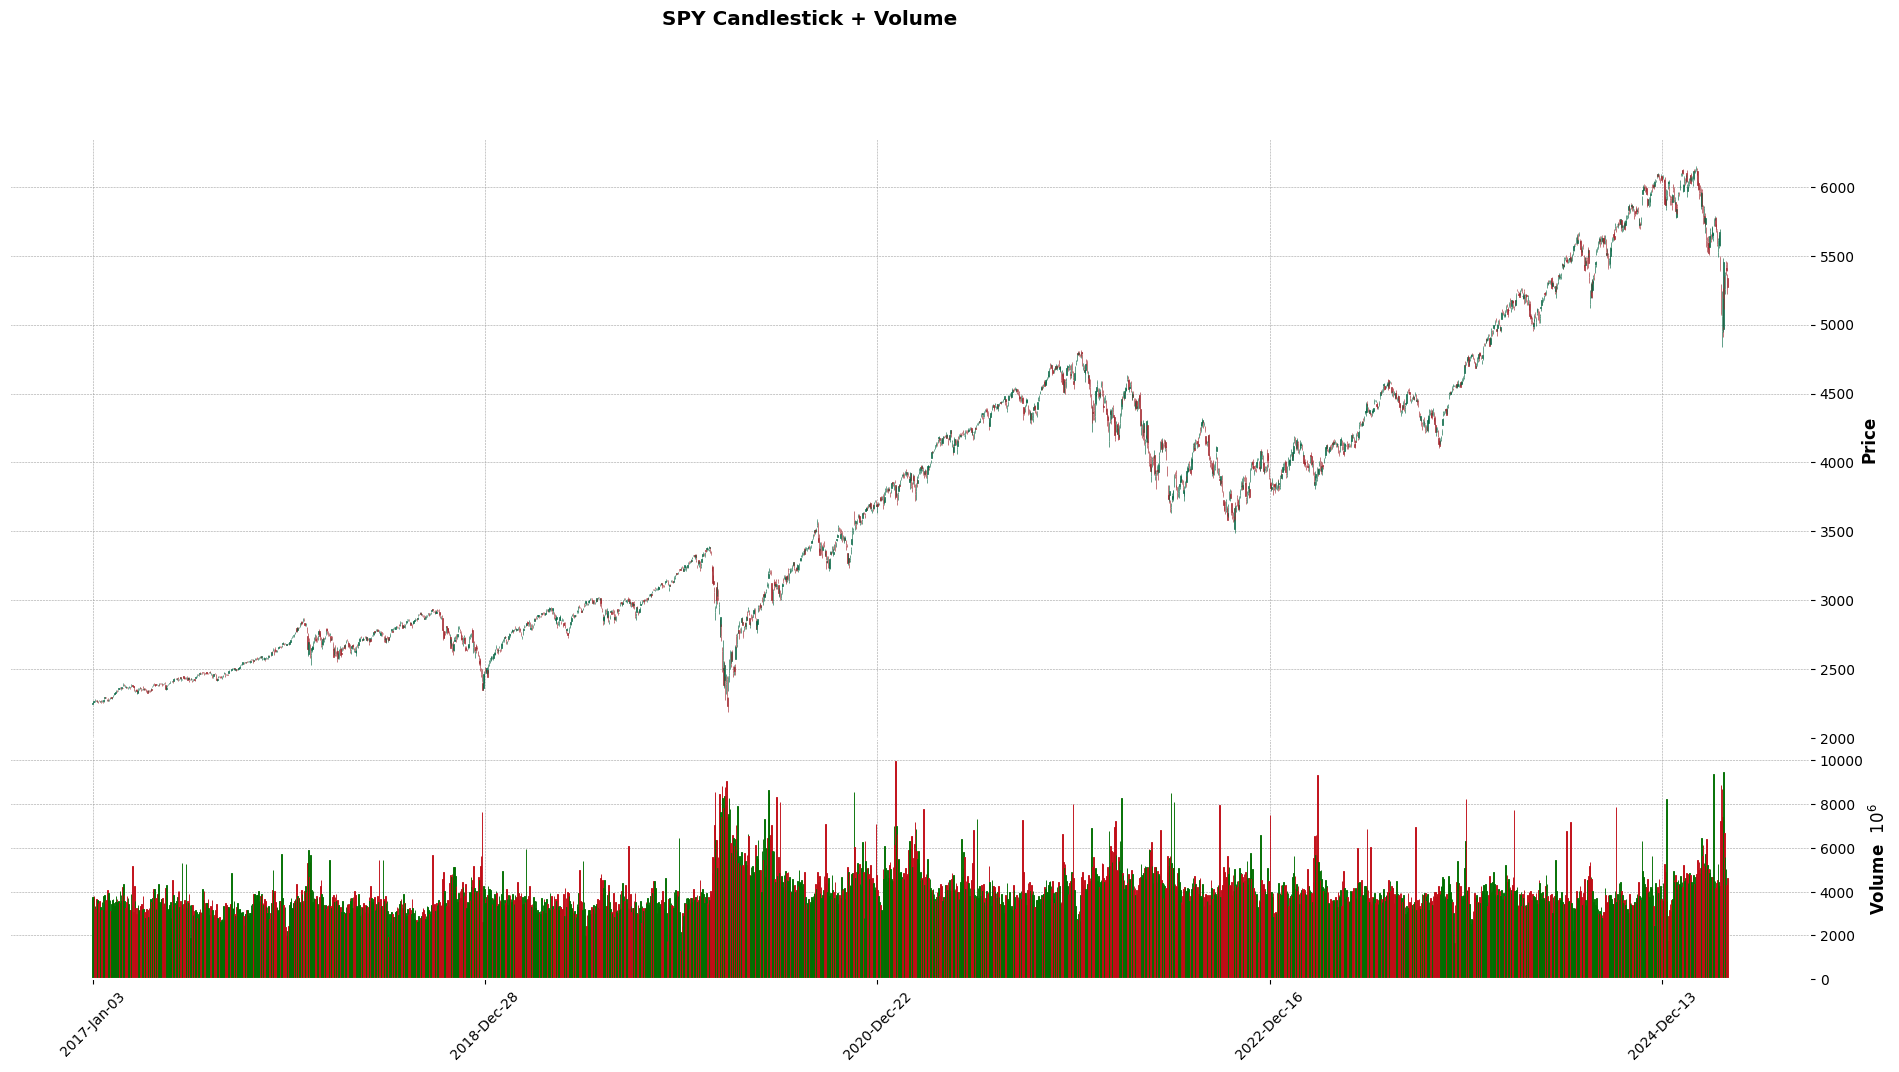

In [163]:
import mplfinance as mpf

mpf.plot(
  df_mpf,
  type='candle',
  volume=True,
  style='charles',
  title='SPY Candlestick + Volume',
  figsize=(25, 12) 
)


### STD of each day 

In [164]:
# Compute daily std‐deviation of [Open, High, Low, Close]
SPY['daily_OHLC_std'] = SPY[['SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close']].std(axis=1)

# Inspect the first few values
print(SPY[['SPY_Open', 'SPY_High', 'SPY_Low', 'SPY_Close', 'daily_OHLC_std']].head())


               SPY_Open     SPY_High      SPY_Low    SPY_Close  daily_OHLC_std
Date                                                                          
2017-01-03  2251.570068  2263.879883  2245.129883  2257.830078        8.070795
2017-01-04  2261.600098  2272.820068  2261.600098  2270.750000        5.940694
2017-01-05  2268.179932  2271.500000  2260.449951  2269.000000        4.768865
2017-01-06  2271.139893  2282.100098  2264.060059  2276.979980        7.761764
2017-01-09  2273.590088  2275.489990  2268.899902  2268.899902        3.347435


In [165]:
SPY['daily_OHLC_std'].max()

np.float64(296.00446517132895)

### Add VIX

In [166]:
#aapl = yf.download("AAPL", start=start, end=end)
#print(data.tail())
VIX = yf.download("^VIX", start=start, end=end)[['Close', 'Volume','High','Low','Open']]
  

VIX.columns = ['VIX_Close', 'VIX_Volume', 'VIX_High', 'VIX_Low', 'VIX_Open']
print(VIX.tail())
#BIT = yf.download("GLD", start=start,end=end)

[*********************100%***********************]  1 of 1 completed

            VIX_Close  VIX_Volume   VIX_High    VIX_Low   VIX_Open
Date                                                              
2025-04-10  40.720001           0  54.869999  34.439999  34.439999
2025-04-11  37.560001           0  46.119999  36.849998  40.799999
2025-04-14  30.889999           0  35.169998  29.750000  34.759998
2025-04-15  30.120001           0  31.450001  28.290001  30.010000
2025-04-16  32.639999           0  34.959999  29.480000  33.240002


### Merge with VIX data

In [167]:
SPY = SPY.join(VIX['VIX_Close'], how='left')

SPY.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SPY_Close       2084 non-null   float64
 1   SPY_Volume      2084 non-null   int64  
 2   SPY_High        2084 non-null   float64
 3   SPY_Low         2084 non-null   float64
 4   SPY_Open        2084 non-null   float64
 5   daily_OHLC_std  2084 non-null   float64
 6   VIX_Close       2084 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 130.2 KB


We can see some correlation between valotility measures(VIX,daily_OHLC_std) and the vollum 

In [168]:
SPY_corr = SPY.copy()
SPY_corr=SPY_corr.drop(['SPY_High','SPY_Low','SPY_Open'], axis=1)
# df is your DataFrame
corr_matrix = SPY_corr.corr(method='pearson')  
# or method='spearman' / 'kendall'

print(corr_matrix)


                SPY_Close  SPY_Volume  daily_OHLC_std  VIX_Close
SPY_Close        1.000000    0.157775        0.314321   0.024942
SPY_Volume       0.157775    1.000000        0.584564   0.650976
daily_OHLC_std   0.314321    0.584564        1.000000   0.641411
VIX_Close        0.024942    0.650976        0.641411   1.000000


### We can see that the STD has some correlation with the vollume

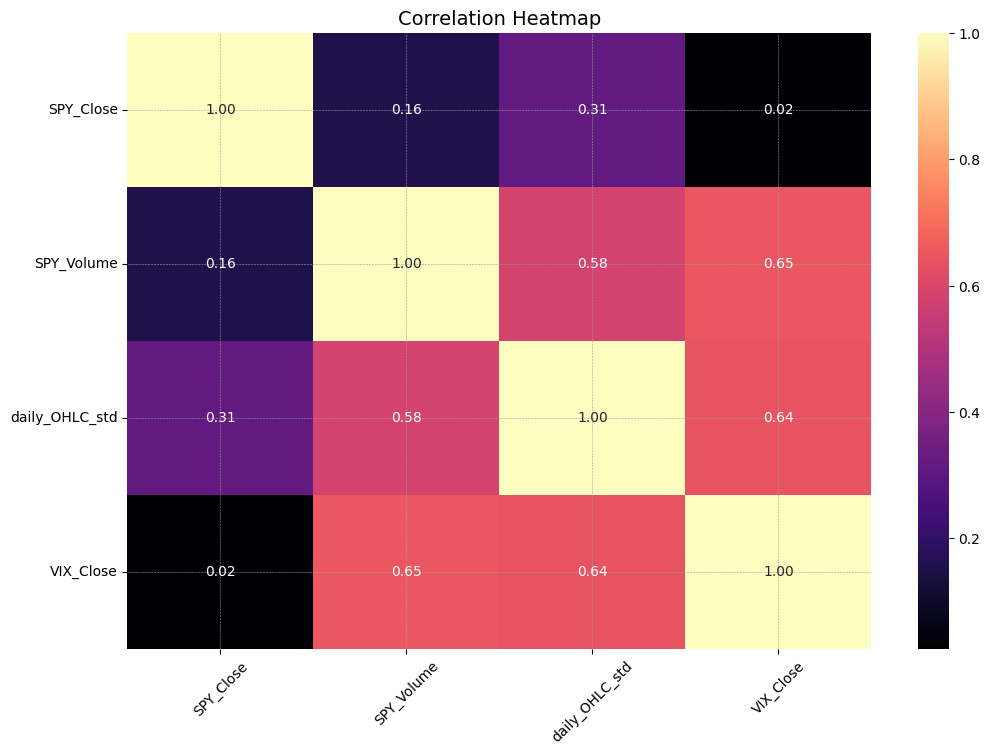

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.heatmap(corr_matrix, cmap='magma', annot=True, fmt=".2f")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(rotation=0)   # Keep y-axis labels horizontal
plt.title("Correlation Heatmap", fontsize=14)
plt.show()

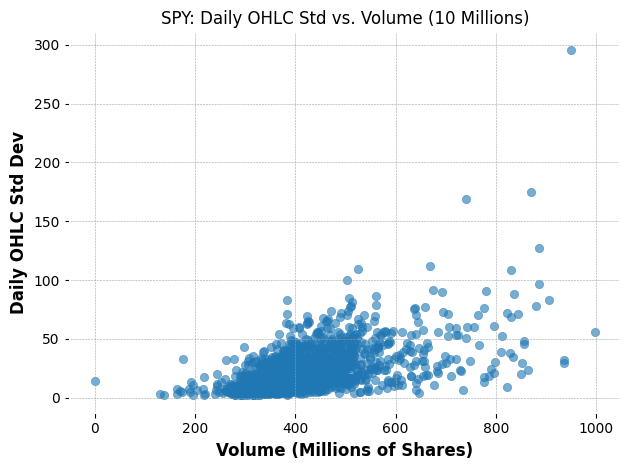

In [170]:


# 1) Create a new column that expresses volume in millions of shares
SPY['Volume_in_Millions'] = SPY['SPY_Volume'] / 1e7

# 2) Plot using the rescaled column
sns.scatterplot(
    data=SPY,
    x='Volume_in_Millions',
    y='daily_OHLC_std',
    alpha=0.6,            # make points slightly transparent, if helpful
    edgecolor=None        # remove borders for large point sets
)
plt.xlabel('Volume (Millions of Shares)')
plt.ylabel('Daily OHLC Std Dev')
plt.title('SPY: Daily OHLC Std vs. Volume (10 Millions)')
plt.tight_layout()
plt.show()


In [171]:
spy = SPY.copy()
spy.reset_index(inplace=True)
spy.rename(columns={'Date': 'ds'}, inplace=True)
spy = spy[['ds','SPY_Close']]

In [172]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2084 entries, 0 to 2083
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         2084 non-null   datetime64[ns]
 1   SPY_Close  2084 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 32.7 KB


# Merge some external data with S&P500 data 

In [271]:

# with this function I can merge the  spy data with the external one in order to chack it 
data_lst = ['Actual_GDP', 'Actual_nonfarm', 'Actual_CPI', 'Actual_PPI','Actual_FOMC','ds']

def merge_data_with_spy(merge, spy, data_lst):
   
    merge = pd.merge(merge[data_lst], spy, on='ds', how='left')
    #merged_df.rename(columns={'SPY_Close': f'SPY_Close_{data}'}, inplace=True)
    return merge

merged = merge_data_with_spy(merged_df, spy, data_lst)



In [272]:

merged = merged.dropna()
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2086 entries, 420 to 2583
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Actual_GDP      2086 non-null   object        
 1   Actual_nonfarm  2086 non-null   object        
 2   Actual_CPI      2086 non-null   object        
 3   Actual_PPI      2086 non-null   object        
 4   Actual_FOMC     2086 non-null   object        
 5   ds              2086 non-null   datetime64[ns]
 6   SPY_Close       2086 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 130.4+ KB


### Save the external data df

In [403]:
merged_df.to_pickle('external_data.pkl')

# Volatility on return data

In [9]:
import sys
# alias numpy._core.numeric → numpy.core.numeric
import numpy.core.numeric as _numeric
sys.modules['numpy._core.numeric'] = _numeric
stocks = pd.read_pickle(r'raw_files/combined_cleaned_add_with_QQQ.pkl')
return_data = pd.read_pickle(r'raw_files/df_with_QQQ.pkl')

In [273]:
return_data.describe()

QQQ_Close         ^RUT         ^VIX       EMA_20       ^GDAXI  \
count  2071.000000  2071.000000  2071.000000  2071.000000  2071.000000   
mean      0.062647     0.027361     0.396394     0.042554     0.036289   
min     -12.321331   -14.272017   -35.753874    -1.889745   -12.238615   
25%      -0.528667    -0.719524    -4.269641    -0.049738    -0.453278   
50%       0.106048     0.063653    -0.720237     0.090249     0.054455   
75%       0.791181     0.840807     3.468655     0.181371     0.626642   
max      12.163161     9.391462   115.597925     0.716581    10.975900   
std       1.456977     1.535198     8.809013     0.233543     1.184608   

              MSFT      stdev_5        ^FTSE         GOOG         AAPL  ...  \
count  2071.000000  2071.000000  2071.000000  2071.000000  2071.000000  ...   
mean      0.106099     0.924341     0.011535     0.083013     0.112068  ...   
min     -14.739043     0.053027   -10.873819   -11.100820   -12.864686  ...   
25%      -0.707872     0.464697    -0.399567    -0.775296    -0.755877  ...   
50%       0.114845     0.731513     0.047962     0.144160     0.117239  ...   
75%       1.008992     1.132105     0.479286     1.025619     1.054381  ...   
max      14.216903     9.449468     9.053047    10.448549    15.328853  ...   
std       1.750862     0.812603     0.976824     1.870852     1.902414  ...   

          DX-Y.NYB        EUR=X  avgreturn10d     2Y_Yield          EUR  \
count  2071.000000  2071.000000   2071.000000  2071.000000  2071.000000   
mean      0.000206    -0.001720      0.050143     0.178445     0.895121   
min      -2.116693    -2.716112     -2.403757   -26.530612     0.799360   
25%      -0.245098    -0.280961     -0.082096    -1.118901     0.856105   
50%       0.000000     0.001178      0.089270     0.000000     0.897300   
75%       0.239230     0.272368      0.233385     1.242236     0.924980   
max       1.652451     2.854382      1.854740    41.666667     1.042080   
std       0.415189     0.461667      0.327814     5.000364     0.045671   

           SPY_RSI          DXY          JPY                             ds  \
count  2071.000000  2071.000000  2071.000000                           2071   
mean     56.947206    98.677673   122.517761  2021-03-03 06:36:19.816513792   
min       4.009864    88.589996   102.678001            2017-01-23 00:00:00   
25%      44.888279    94.050003   109.124500            2019-02-12 12:00:00   
50%      58.511336    97.709999   112.556000            2021-03-04 00:00:00   
75%      68.316484   103.355000   139.493500            2023-03-23 12:00:00   
max      96.234267   114.110001   161.606995            2025-04-16 00:00:00   
std      16.391022     5.422531    17.542874                            NaN   

        SPY_return  
count  2071.000000  
mean      0.047963  
min     -11.984055  
25%      -0.388212  
50%       0.075840  
75%       0.616863  
max       9.515388  
std       1.203159  

[8 rows x 47 columns]

In [10]:
#print(return_data.columns.to_list())
# Ensure 'ds' is in datetime format
return_data['abs_vol'].head(20)

0     3155240000
1     3816950000
2     3849340000
3     3611510000
4     3137420000
5     3595040000
6     4089730000
7     3919190000
8     3809760000
9     3605970000
10    3112390000
11    3452460000
12    3611950000
13    3681600000
14    3496600000
15    3352370000
16    3528040000
17    3785870000
18    3675900000
19    3516830000
Name: abs_vol, dtype: int64

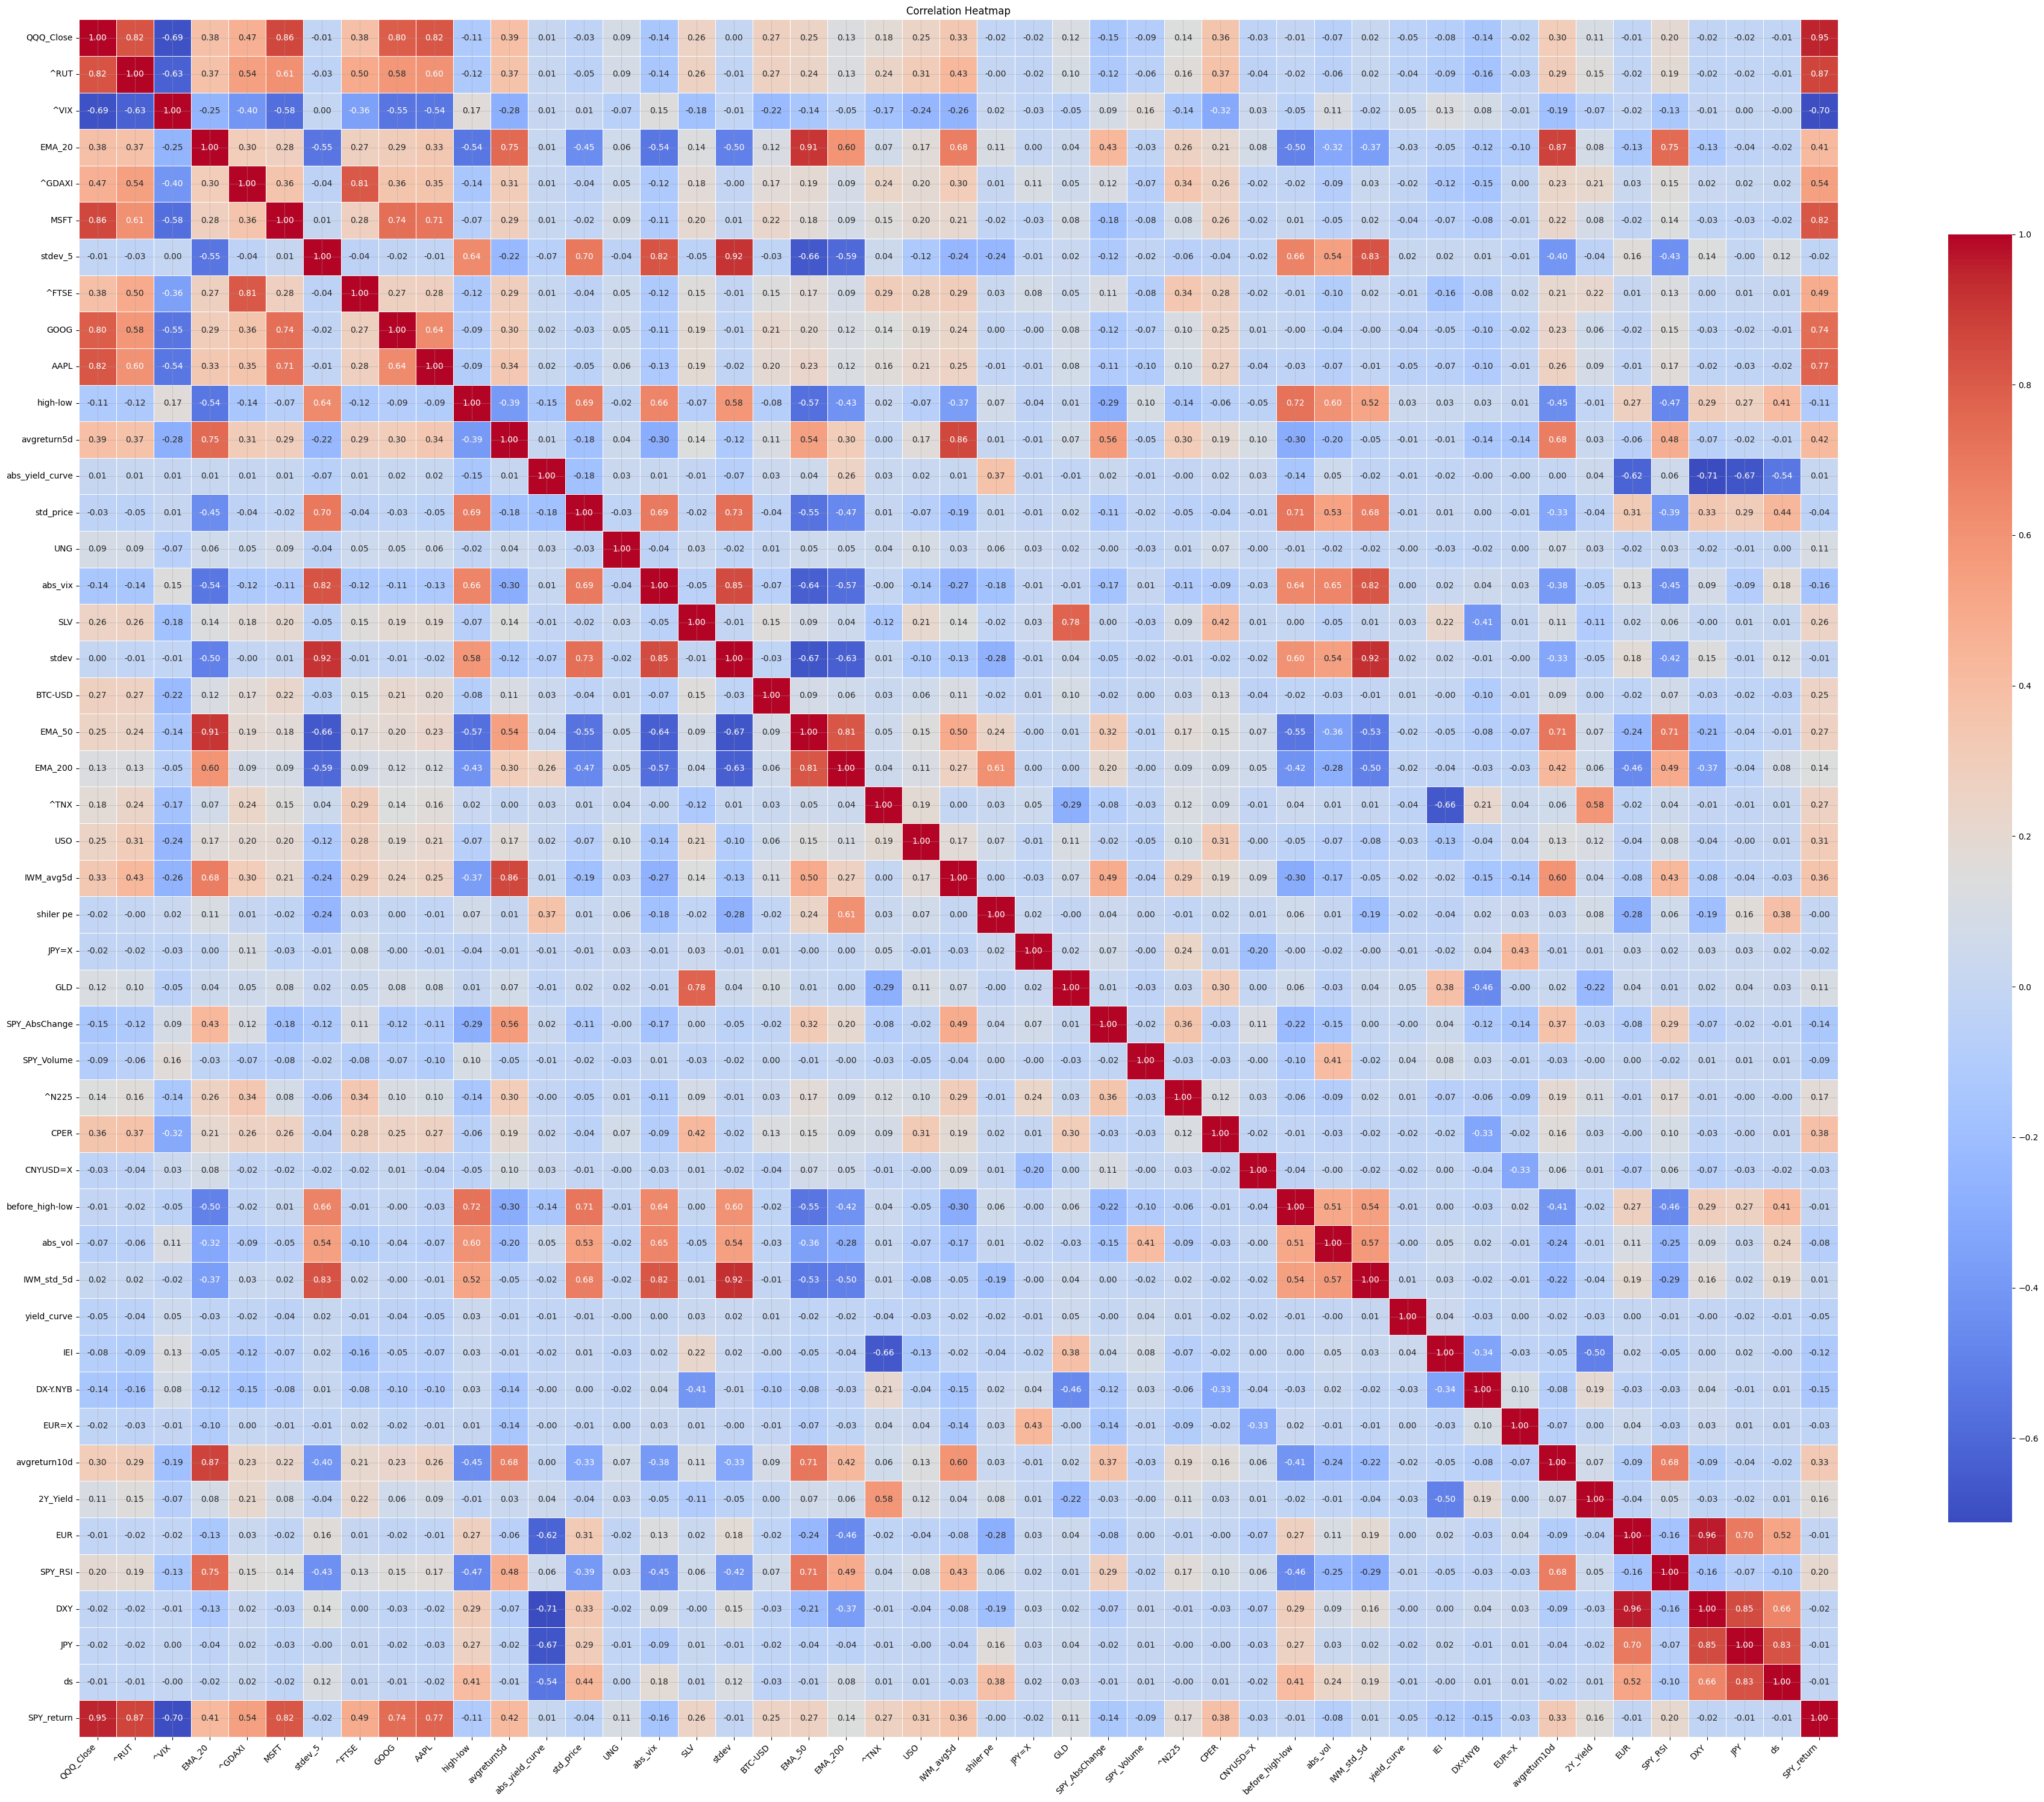

In [274]:
def plot_correlation_heatmap(df, figsize=(38, 30), cmap="coolwarm", annot=True, fmt=".2f"):
    """
    Plots a correlation heatmap for all numeric columns in df.

    Parameters:
    - df: pandas.DataFrame
    - figsize: tuple, size of the figure in inches
    - cmap: str, matplotlib colormap for the heatmap
    - annot: bool, whether to annotate cells with correlation values
    - fmt: str, formatting string for annotations
    """
    # 1) Compute the correlation matrix
    corr = df.corr()

    # 2) Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        cmap=cmap,
        annot=annot,
        fmt=fmt,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )
    plt.title("Correlation Heatmap")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Usage:
plot_correlation_heatmap(return_data)

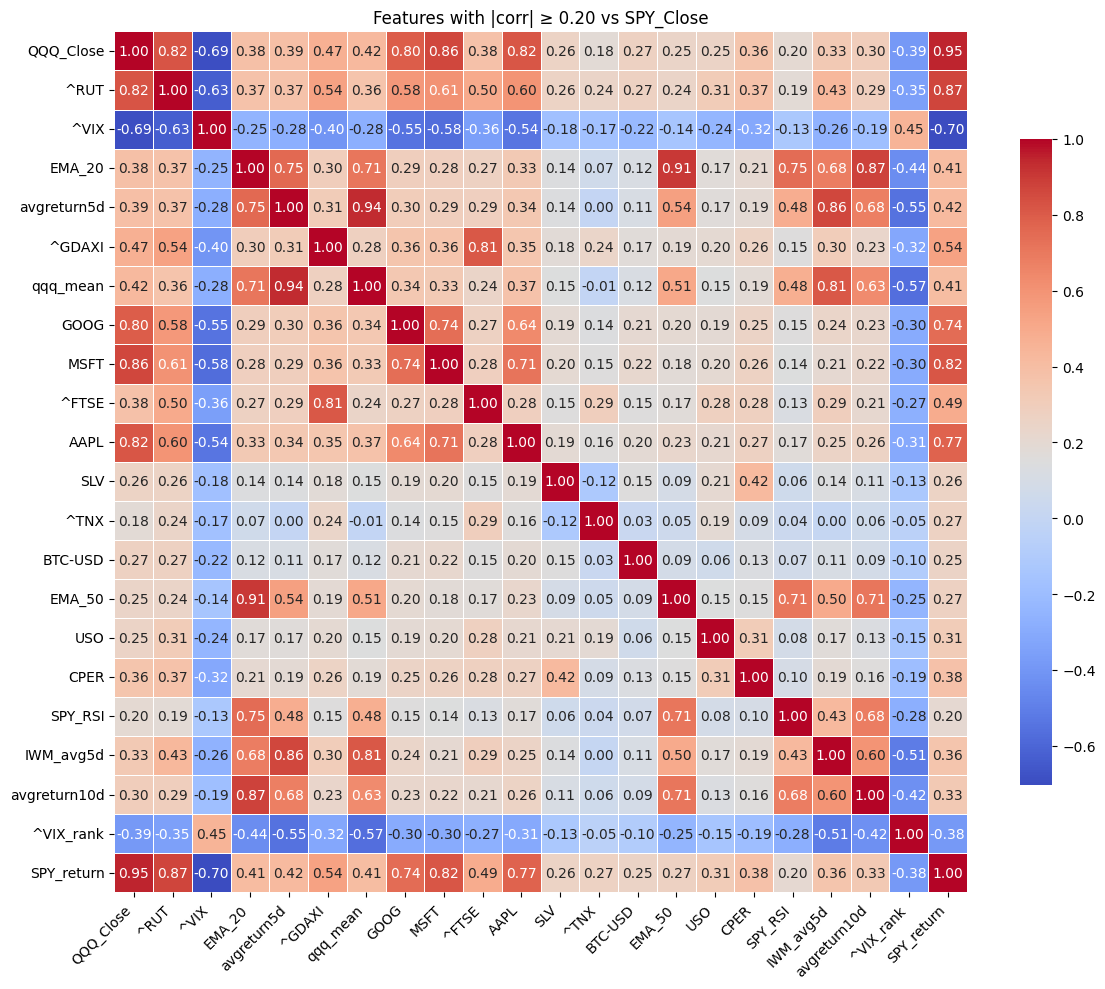

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_spy_correlated_heatmap(df,
                                threshold: float = 0.2,
                                figsize=(12, 10),
                                cmap="coolwarm",
                                annot=True,
                                fmt=".2f"):
    """
    Plots a correlation heatmap, but only for those features whose absolute
    correlation with SPY_Close is >= threshold.

    Parameters:
    - df: pandas.DataFrame
    - threshold: float, cutoff on |corr(feature, SPY_Close)| to include in the plot
    - figsize, cmap, annot, fmt: passed to sns.heatmap
    """
    # 1) full correlation matrix
    corr = df.corr()

    # 2) find features with |corr| >= threshold
    mask = corr["SPY_return"].abs() >= threshold
    features = corr.index[mask].tolist()

    # 3) slice out only those features (including SPY_Close itself)
    sub_corr = corr.loc[features, features]

    # 4) plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        sub_corr,
        cmap=cmap,
        annot=annot,
        fmt=fmt,
        linewidths=0.5,
        cbar_kws={"shrink": 0.75}
    )
    plt.title(f"Features with |corr| ≥ {threshold:.2f} vs SPY_Close")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_spy_correlated_heatmap(return_data, threshold=0.2)

Higher volatility does not necceserely means negative return, a big UP day can happend in an envirioment of high vol (mostly after a big sell-off in stocks)

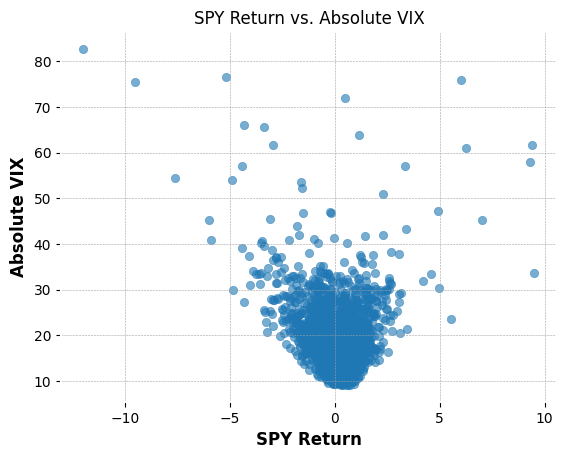

In [179]:
sns.scatterplot(data=return_data,x='SPY_return',y='abs_vix', alpha=0.6, edgecolor=None)
plt.xlabel('SPY Return')
plt.ylabel('Absolute VIX')
plt.title('SPY Return vs. Absolute VIX')
plt.show()

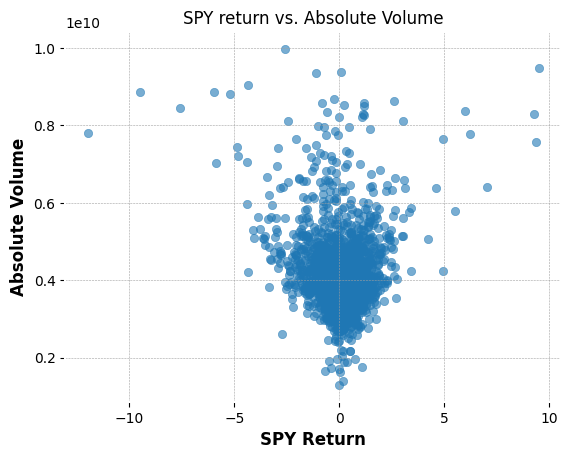

In [180]:
sns.scatterplot(data=return_data,x='SPY_return',y='abs_vol', alpha=0.6, edgecolor=None)
plt.xlabel('SPY Return')
plt.ylabel('Absolute Volume')
plt.title('SPY return vs. Absolute Volume')
plt.show()

# Daily return and economic data realeses:

In [181]:
spy_pct = return_data.copy()
spy_pct.reset_index(inplace=True)
spy_pct.rename(columns={'Date': 'ds'}, inplace=True)
spy_pct = spy_pct[['ds','SPY_return']]

In [182]:
print(return_data.columns.to_list())

['QQQ_Close', '^RUT', '^VIX', 'EMA_20', '^GDAXI', 'MSFT', 'stdev_5', '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d', 'abs_yield_curve', 'std_price', 'UNG', 'abs_vix', 'SLV', 'stdev', 'BTC-USD', 'EMA_50', 'EMA_200', '^TNX', 'USO', 'IWM_avg5d', 'shiler pe', 'JPY=X', 'GLD', 'SPY_AbsChange', 'SPY_Volume', '^N225', 'CPER', 'CNYUSD=X', 'before_high-low', 'abs_vol', 'IWM_std_5d', 'yield_curve', 'IEI', 'DX-Y.NYB', 'EUR=X', 'avgreturn10d', '2Y_Yield', 'EUR', 'SPY_RSI', 'DXY', 'JPY', 'ds', 'SPY_return']


In [275]:


data_lst = ['Actual_GDP', 'Actual_nonfarm', 'Actual_CPI', 'Actual_PPI','Actual_FOMC','ds','Actual_unemployment rate']


merged = merge_data_with_spy(merged_df, spy_pct, data_lst)



In [276]:

merged = merged.dropna()
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2073 entries, 434 to 2583
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Actual_GDP                2073 non-null   object        
 1   Actual_nonfarm            2073 non-null   object        
 2   Actual_CPI                2073 non-null   object        
 3   Actual_PPI                2073 non-null   object        
 4   Actual_FOMC               2073 non-null   object        
 5   ds                        2073 non-null   datetime64[ns]
 6   Actual_unemployment rate  2073 non-null   object        
 7   SPY_return                2073 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 145.8+ KB


### Plot return vs actual data

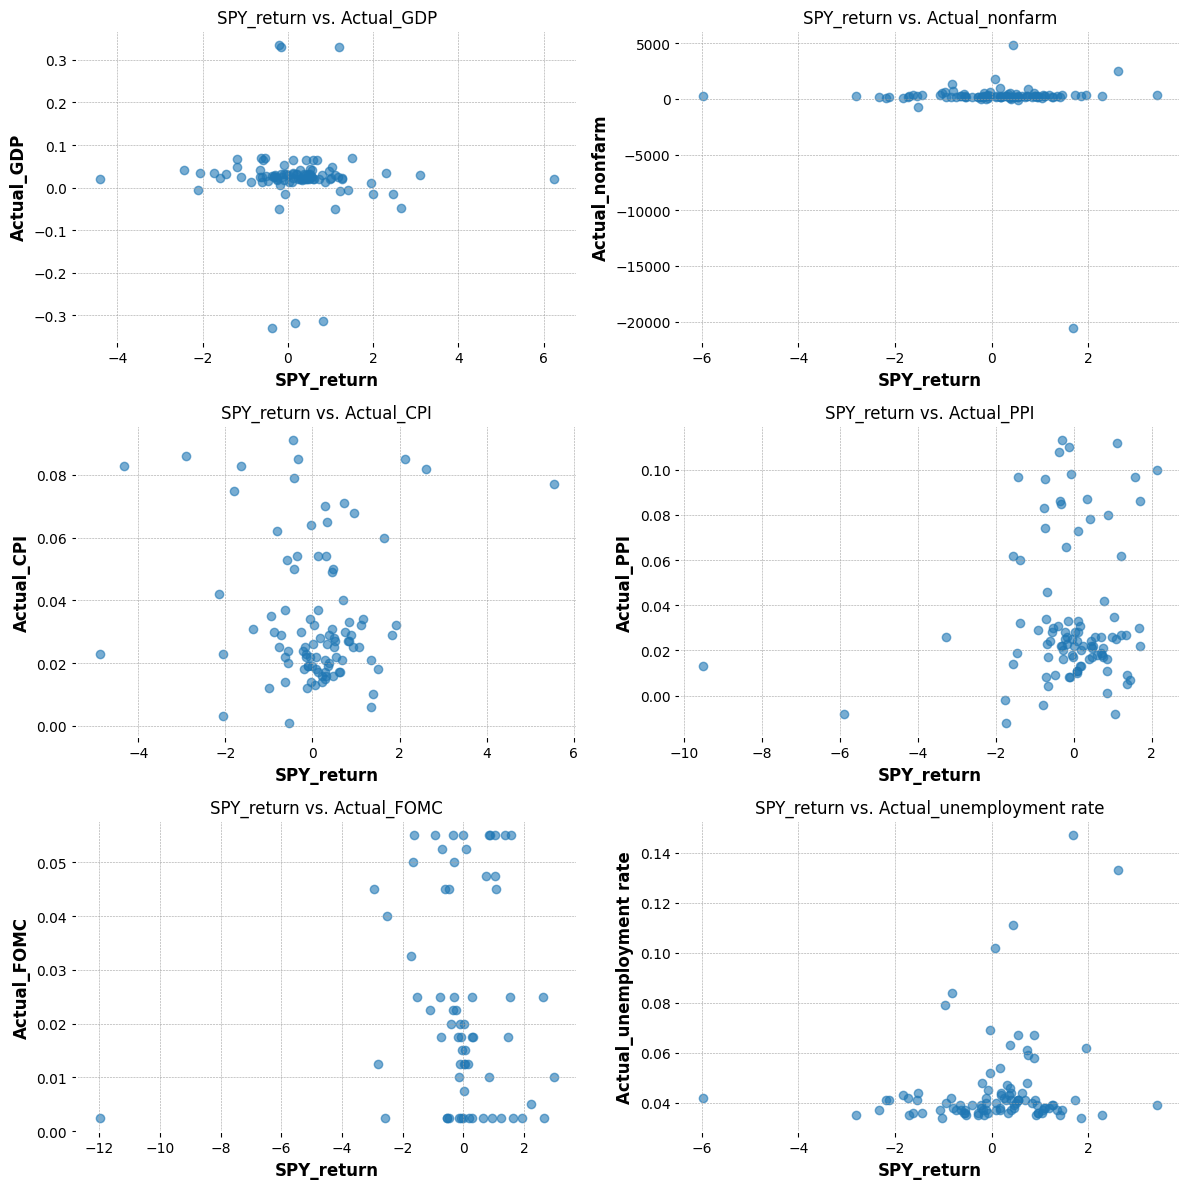

In [277]:
def plot_scatter_grid(df, target='SPY_return', exclude_cols=None, n_cols=2):
    """
    Plots a grid of scatterplots comparing the target column against each other numeric feature.

    Parameters:
    - df: pandas.DataFrame containing the data (must include `target` and other numeric features).
    - target: str, name of the column to plot on the x-axis.
    - exclude_cols: list of str, additional columns to exclude from features (beside `target`).
    - n_cols: int, number of columns in the subplot grid.
    """
    # Ensure target is always excluded
    if exclude_cols is None:
        exclude_cols = []
    exclude = set(exclude_cols) | {target}

    # Identify feature columns (excluding target and any others)
    features = [c for c in df.columns if c not in exclude]
    
    # Convert feature columns to numeric (coerce errors to NaN)
    for col in features:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Determine grid size
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
    axes = axes.flatten()
    
    # Plot each scatter
    for ax, feat in zip(axes, features):
        ax.scatter(df[target], df[feat], alpha=0.6)
        ax.set_title(f'{target} vs. {feat}')
        ax.set_xlabel(target)
        ax.set_ylabel(feat)
    
    # Remove any unused axes
    for ax in axes[n_features:]:
        fig.delaxes(ax)
    
    plt.tight_layout()
    plt.show()

# Example usage:
plot_scatter_grid(merged, target='SPY_return', exclude_cols=['ds'], n_cols=2)

As it seems the CPI data is the most influencial on the price movments

In [278]:
lst_yields = ['10year_gap','10year_sign','20year_gap','20year_sign','2year_gap','2year_sign','ds']
merge_yield = merge_data_with_spy(merged_df,spy_pct,lst_yields)
merge_yield.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   10year_gap   115 non-null    float64       
 1   10year_sign  115 non-null    float64       
 2   20year_gap   59 non-null     float64       
 3   20year_sign  59 non-null     float64       
 4   2year_gap    107 non-null    float64       
 5   2year_sign   107 non-null    float64       
 6   ds           2592 non-null   datetime64[ns]
 7   SPY_return   2073 non-null   float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 162.1 KB


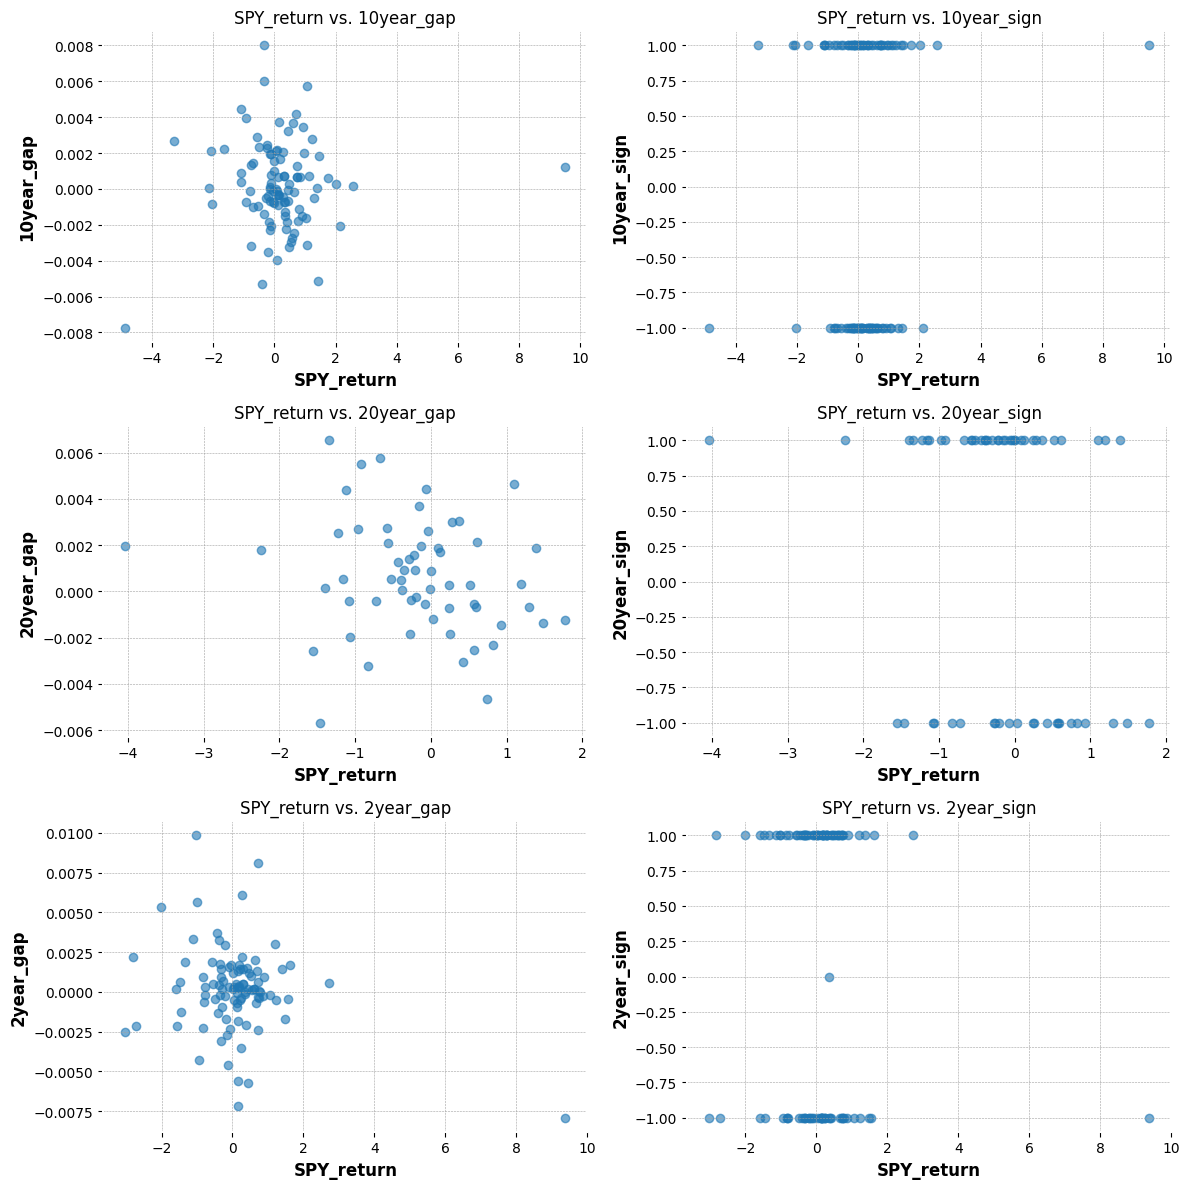

In [279]:
plot_scatter_grid(merge_yield, target='SPY_return', exclude_cols=['ds'], n_cols=2)

### Now i will show the volatility on event data 

In [198]:
def merge_data_with_spy_1(merge, spy, data_lst):
   
    merge = pd.merge(spy,merge[data_lst], on='ds', how='left')
    #merged_df.rename(columns={'SPY_Close': f'SPY_Close_{data}'}, inplace=True)
    return merge

lst_cols = ['ds','event']
return_data_2 = return_data[['SPY_return','abs_vix','abs_vol','ds']]
merge_data_days = merge_data_with_spy_1(merged_df, return_data_2, lst_cols)

merge_data_days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SPY_return  2072 non-null   float64       
 1   abs_vix     2072 non-null   float64       
 2   abs_vol     2072 non-null   int64         
 3   ds          2072 non-null   datetime64[ns]
 4   event       537 non-null    object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 81.1+ KB


In [199]:
merge_data_days['event'] = merge_data_days['event'].replace(np.nan , 'none event')
merge_data_days.head(20)

SPY_return  abs_vix     abs_vol         ds  \
0    -0.269012    11.77  3155240000 2017-01-23   
1     0.656459    11.07  3816950000 2017-01-24   
2     0.802609    10.81  3849340000 2017-01-25   
3    -0.073538    10.63  3611510000 2017-01-26   
4    -0.086646    10.58  3137420000 2017-01-27   
5    -0.600954    11.88  3595040000 2017-01-30   
6    -0.088991    11.99  4089730000 2017-01-31   
7     0.029836    11.81  3919190000 2017-02-01   
8     0.057031    11.93  3809760000 2017-02-02   
9     0.726476    10.97  3605970000 2017-02-03   
10   -0.211536    11.37  3112390000 2017-02-06   
11    0.022683    11.29  3452460000 2017-02-07   
12    0.069332    11.45  3611950000 2017-02-08   
13    0.575255    10.88  3681600000 2017-02-09   
14    0.356605    10.85  3496600000 2017-02-10   
15    0.524585    11.07  3352370000 2017-02-13   
16    0.400734    10.74  3528040000 2017-02-14   
17    0.499231    11.97  3785870000 2017-02-15   
18   -0.086412    11.76  3675900000 2017-02-16   
19    0.167856    11.49  3516830000 2017-02-17   

                                       event  
0                                 none event  
1                                 none event  
2                                 none event  
3                                 none event  
4                                 Actual_GDP  
5                            Actual_core_PCE  
6                                 none event  
7                                Actual_FOMC  
8                                 none event  
9   Actual_nonfarm, Actual_unemployment rate  
10                                none event  
11                                none event  
12                                none event  
13                                none event  
14                                none event  
15                                none event  
16                                Actual_PPI  
17                                Actual_CPI  
18                                none event  
19                                none event

In [200]:
merge_data_days = merge_data_days.dropna()
merge_data_days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SPY_return  2072 non-null   float64       
 1   abs_vix     2072 non-null   float64       
 2   abs_vol     2072 non-null   int64         
 3   ds          2072 non-null   datetime64[ns]
 4   event       2072 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 81.1+ KB


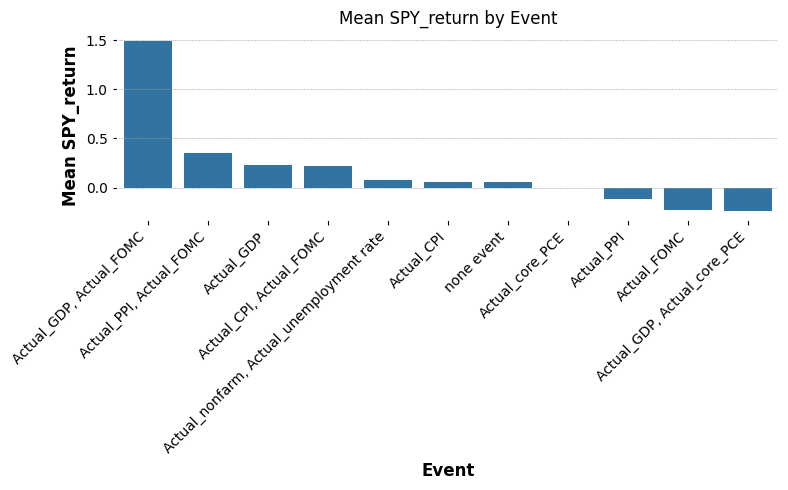

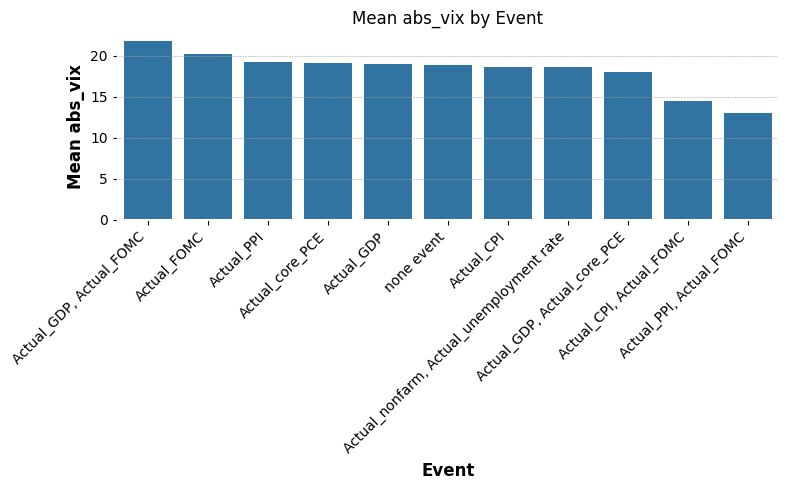

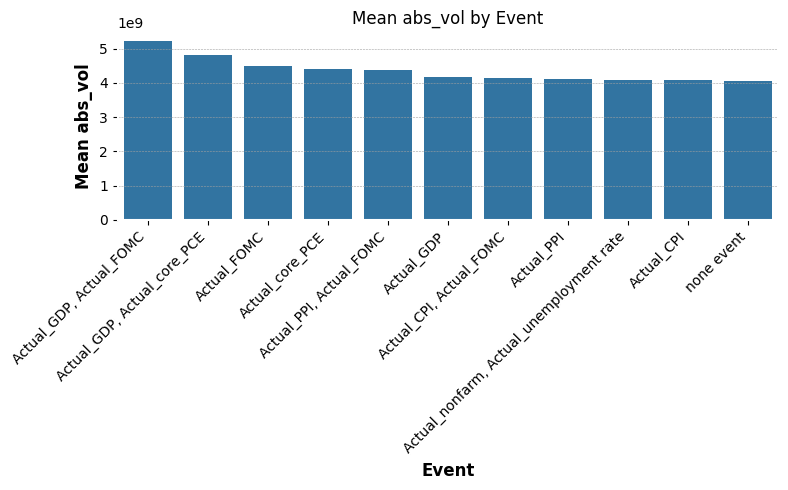

In [201]:

def plot_event_means(df):
    """
    Given a DataFrame with columns ['event','SPY_return','abs_vix','abs_vol'],
    produces three barplots of mean value per event.
    """
    cols = ['SPY_return', 'abs_vix', 'abs_vol']
    for col in cols:
        # 1) Compute mean per event
        means = df.groupby('event')[col].mean().reset_index()

        # 2) Plot
        plt.figure(figsize=(8, 5))
        sns.barplot(data=means, x='event', y=col, 
                    order=means.sort_values(col, ascending=False)['event'])
        plt.title(f'Mean {col} by Event')
        plt.xlabel('Event')
        plt.ylabel(f'Mean {col}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

plot_event_means(merge_data_days)


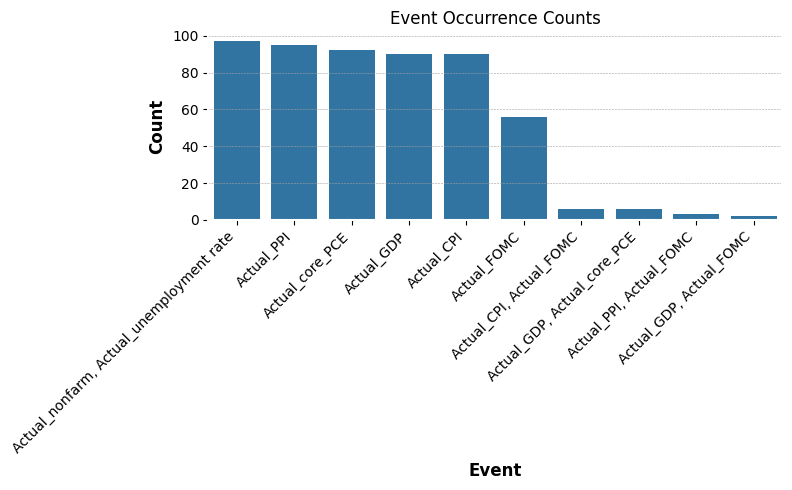

In [ ]:
# count the number 
def plot_event_counts(df):
    """
    Plots a bar chart showing the number of occurrences of each unique value in df['event'].
    """
    # 1) Count occurrences
    counts = df['event'].value_counts().reset_index()
    counts.columns = ['event', 'count']
    
    # 2) Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=counts,
        x='event',
        y='count',
        order=counts.sort_values('count', ascending=False)['event']
    )
    plt.title('Event Occurrence Counts')
    plt.xlabel('Event')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# I want only the event days
merge_event = merge_data_days.copy()
merge_event = merge_event[merge_event['event'] != 'none event'].copy()


plot_event_counts(merge_event)


In [207]:
merge_event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   SPY_return  2072 non-null   float64       
 1   abs_vix     2072 non-null   float64       
 2   abs_vol     2072 non-null   int64         
 3   ds          2072 non-null   datetime64[ns]
 4   event       2072 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 81.1+ KB


In [189]:
print(merged_df.columns.to_list())

['ds', 'Actual_GDP', 'Actual_nonfarm', 'Actual_CPI', 'Actual_PPI', 'Actual_unemployment rate', 'Actual_core_PCE', 'Actual_FOMC', 'CPI_vs_forecast', 'CPI_vs_previous', 'GDP_vs_forecast', 'GDP_vs_previous', 'PPI_vs_forecast', 'PPI_vs_previous', 'nonfarm_vs_forecast', 'nonfarm_vs_previous', 'unemployment rate_vs_forecast', 'unemployment rate_vs_previous', 'core_PCE_vs_forecast', 'core_PCE_vs_previous', 'FOMC_vs_forecast', 'FOMC_vs_previous', 'event', 'holiday', 'shiler pe', 'Actual_20year', '20year_gap', '20year_sign', 'Actual_10year', '10year_gap', '10year_sign', 'Actual_2year', '2year_gap', '2year_sign']


### Plot returns on data days for bellow ,at and above estimate release

In [209]:
lst =['CPI_vs_forecast', 'GDP_vs_forecast', 'PPI_vs_forecast', 'nonfarm_vs_forecast','unemployment rate_vs_forecast', 'core_PCE_vs_forecast', 'FOMC_vs_forecast','ds']
merged_vs_forecast = merge_data_with_spy(merged_df, return_data_2, lst)
merged_vs_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   CPI_vs_forecast                155 non-null    float64       
 1   GDP_vs_forecast                204 non-null    float64       
 2   PPI_vs_forecast                155 non-null    float64       
 3   nonfarm_vs_forecast            206 non-null    float64       
 4   unemployment rate_vs_forecast  201 non-null    float64       
 5   core_PCE_vs_forecast           119 non-null    float64       
 6   FOMC_vs_forecast               135 non-null    float64       
 7   ds                             973 non-null    datetime64[ns]
 8   SPY_return                     539 non-null    float64       
 9   abs_vix                        539 non-null    float64       
 10  abs_vol                        539 non-null    float64       
dtypes: datetime64[ns](1

There is 3 diffrent values for each data columns [-1,0,1] when {-1 : the actual data was lower than expected , 0 : as expected , 1: higher than expected} I am ploting to see for each data column what is the mean SPY return 

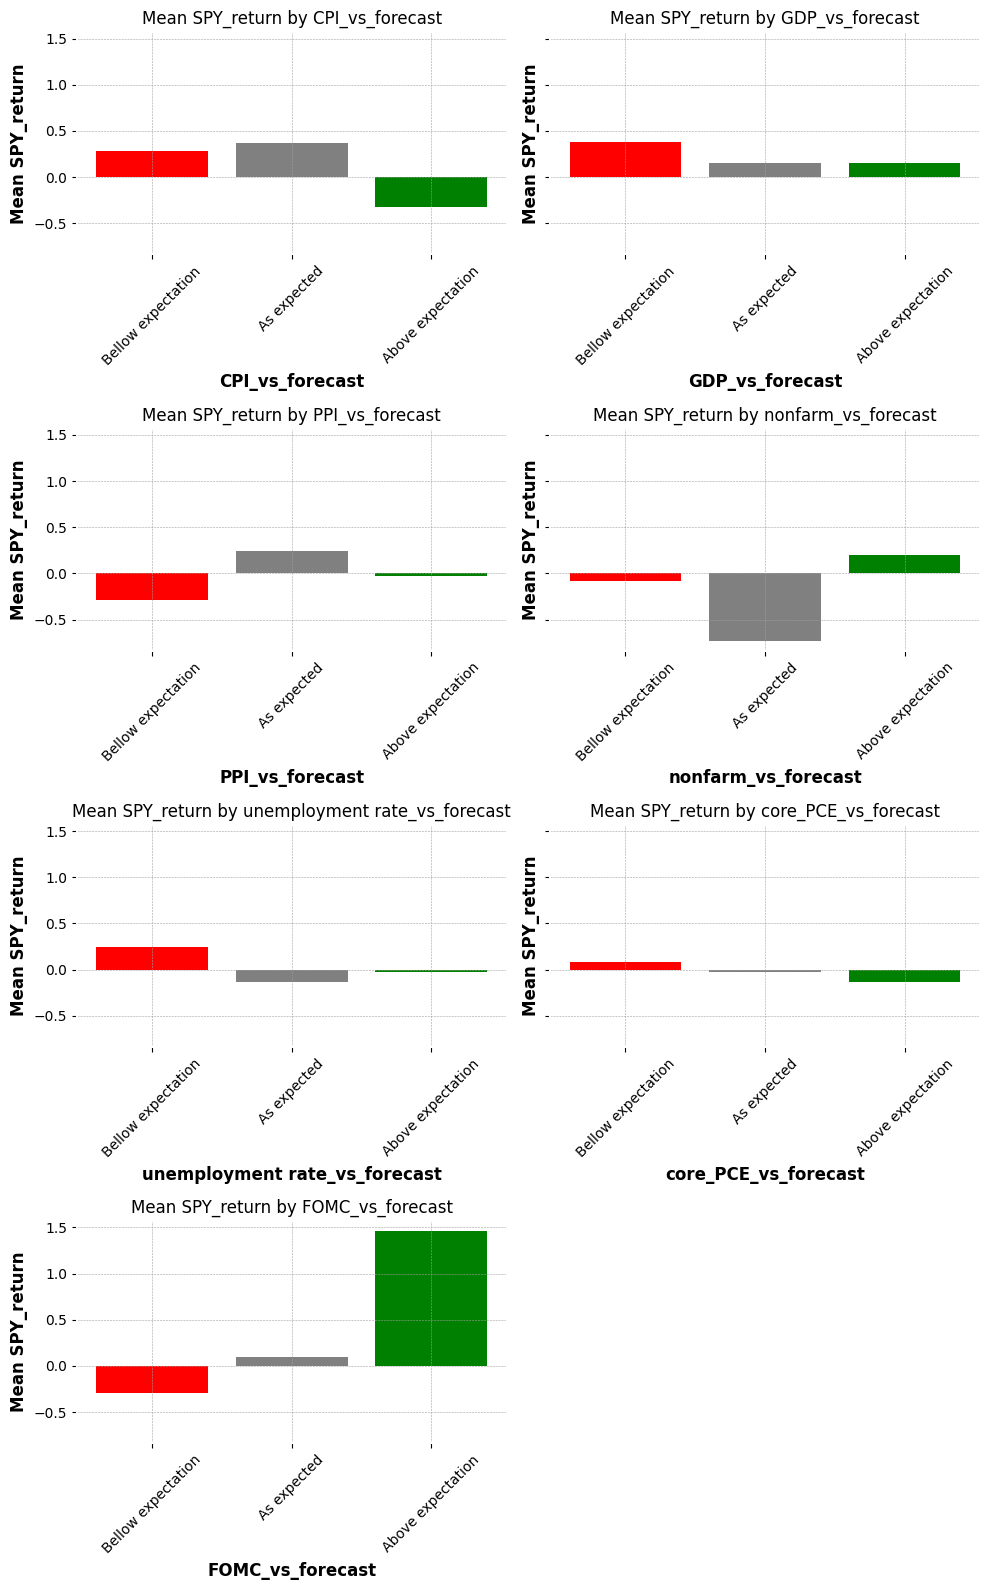

In [210]:
lst1 =['CPI_vs_forecast', 'GDP_vs_forecast', 'PPI_vs_forecast', 'nonfarm_vs_forecast','unemployment rate_vs_forecast', 'core_PCE_vs_forecast', 'FOMC_vs_forecast']

def plot_combined_mean_barplots(df, target, features, category_mapping, n_cols=2, subplot_size=(6, 4)):
    """
    Plots multiple barplots (one per feature) of mean(target) by categorical feature,
    all in one combined figure.

    Parameters:
    - df: pandas DataFrame containing data
    - target: str, name of the target column (e.g., 'SPY_return')
    - features: list of str, names of categorical features with values matching keys in category_mapping
    - category_mapping: dict mapping original category values to display labels
    - n_cols: int, number of subplot columns
    - subplot_size: tuple(width, height) in inches per subplot
    """
    # Determine grid layout
    n_features = len(features)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(subplot_size[0] * n_cols, subplot_size[1] * n_rows), sharey=True)
    axes = axes.flatten()
    
    # For each feature, compute mean target by category and plot
    for idx, feat in enumerate(features):
        ax = axes[idx]
        
        # Compute mean by category, ensure all categories present
        mean_series = df.groupby(feat)[target].mean().reindex(category_mapping.keys())
        
        # Map index values to labels
        labels = [category_mapping[k] for k in mean_series.index]
        values = mean_series.values
        
        # Plot bar chart
        ax.bar(labels, values, color=['red', 'gray', 'green'])
        ax.set_title(f'Mean {target} by {feat}')
        ax.set_xlabel(feat)
        ax.set_ylabel(f'Mean {target}')
        ax.tick_params(axis='x', rotation=45)
    
    # Remove unused subplots
    for j in range(n_features, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Example usage:
category_labels = {-1: "Bellow expectation", 0: "As expected", 1: "Above expectation"}
# features = ['unemployment_rate_vs_forecast', 'Actual_GDP', ...]
plot_combined_mean_barplots(merged_vs_forecast, 'SPY_return', lst1, category_labels, n_cols=2, subplot_size=(5, 4))

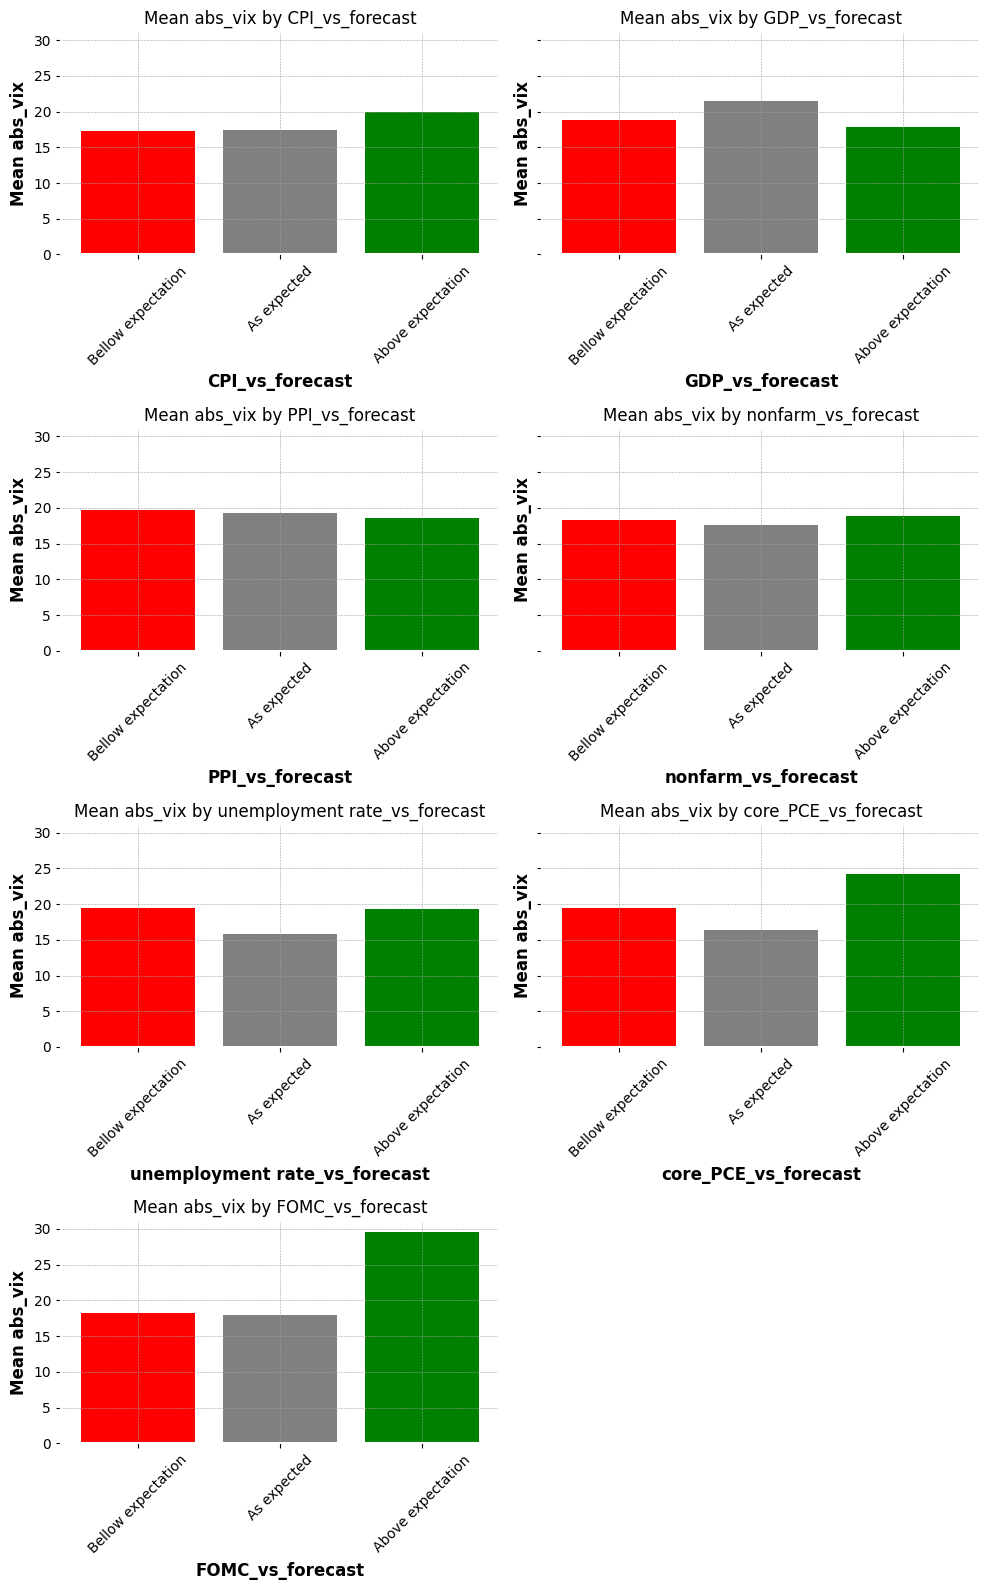

In [121]:
plot_combined_mean_barplots(merged_vs_forecast, 'abs_vix', lst1, category_labels, n_cols=2, subplot_size=(5, 4))

In [208]:
return_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QQQ_Close        2071 non-null   float64       
 1   ^RUT             2071 non-null   float64       
 2   ^VIX             2071 non-null   float64       
 3   EMA_20           2071 non-null   float64       
 4   ^GDAXI           2071 non-null   float64       
 5   MSFT             2071 non-null   float64       
 6   stdev_5          2071 non-null   float64       
 7   ^FTSE            2071 non-null   float64       
 8   GOOG             2071 non-null   float64       
 9   AAPL             2071 non-null   float64       
 10  high-low         2071 non-null   float64       
 11  avgreturn5d      2071 non-null   float64       
 12  abs_yield_curve  2071 non-null   float64       
 13  std_price        2071 non-null   float64       
 14  UNG              2071 non-null   float64

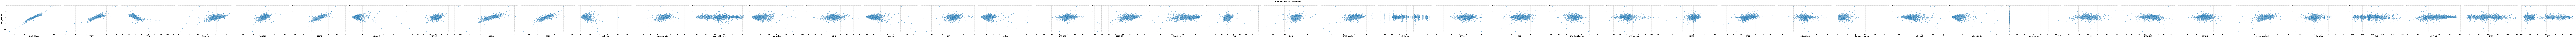

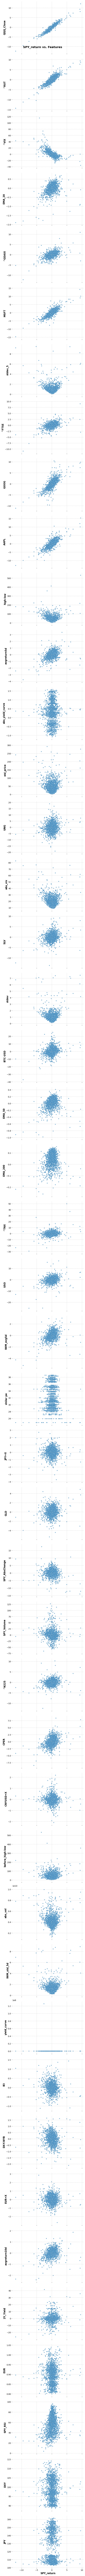

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pairgrid_vs_target(
    df,
    target='SPY_return',
    exclude_cols=None,
    orientation='horizontal',
    height=4,
    aspect=1.2,
    margin_top=0.9
):
    """
    Uses Seaborn's PairGrid to create a row or column of scatter plots of target vs. each feature,
    excluding `target` and any additional columns (e.g. 'ds').

    Parameters:
    - df: pandas.DataFrame
    - target:    str, name of the column to appear on one axis (x if horizontal, y if vertical)
    - exclude_cols: list of str, additional columns to drop from plotting
    - orientation: 'horizontal' (one row) or 'vertical' (one column)
    - height:    float, height of each subplot in inches
    - aspect:    float, aspect ratio = width/height of each subplot
    - margin_top: float, fraction of figure height reserved above subplots for title
    """
    if exclude_cols is None:
        exclude_cols = []
    # Always exclude ds + target
    to_exclude = set(exclude_cols) | {target}
    features = [c for c in df.columns if c not in to_exclude]

    # Determine grid dims
    n = len(features)
    if orientation == 'horizontal':
        x_vars = features
        y_vars = [target]
        n_rows, n_cols = 1, n
        fig_w = height * aspect * n_cols
        fig_h = height * n_rows
    else:  # vertical
        x_vars = [target]
        y_vars = features
        n_rows, n_cols = n, 1
        fig_w = height * aspect * n_cols
        fig_h = height * n_rows

    # Build the PairGrid
    grid = sns.PairGrid(
        df,
        x_vars=x_vars,
        y_vars=y_vars,
        height=height,
        aspect=aspect
    )
    grid.map(sns.scatterplot, s=20, alpha=0.6)

    # Resize the figure to fit all subplots
    grid.fig.set_size_inches(fig_w, fig_h)
    grid.fig.subplots_adjust(top=margin_top)

    # Title
    direction = ' vs. '.join(
        ([target] if orientation=='horizontal' else [''] ) +
        features if orientation=='horizontal' else ([target] + features)
    )
    grid.fig.suptitle(f'{target} vs. Features', y=0.98)

    plt.tight_layout()
    plt.show()

# Example Usage:
# For a wide row of plots:
plot_pairgrid_vs_target(
    return_data,
    target='SPY_return',
    exclude_cols=['ds'],
    orientation='horizontal',
    height=4,
    aspect=1.5
)

# Or, for a tall column of plots (often easier to scroll vertically):
plot_pairgrid_vs_target(
    return_data,
    target='SPY_return',
    exclude_cols=['ds'],
    orientation='vertical',
    height=4,
    aspect=1.5
)



In [211]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2055 entries, 0 to 2054
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ds                   2055 non-null   datetime64[ns]
 1   SPY_Close            2055 non-null   float64       
 2   SPY_Volume           2055 non-null   int64         
 3   AAPL                 2055 non-null   float64       
 4   MSFT                 2055 non-null   float64       
 5   GOOG                 2055 non-null   float64       
 6   GLD                  2055 non-null   float64       
 7   SLV                  2055 non-null   float64       
 8   ^TNX                 2055 non-null   float64       
 9   DX-Y.NYB             2055 non-null   float64       
 10  JPY=X                2055 non-null   float64       
 11  EUR=X                2055 non-null   float64       
 12  USO                  2055 non-null   float64       
 13  UNG                  2055 non-nul

## display to top 20 most correlated 

### For absolute values :

In [ ]:

def top_n_correlated(df: pd.DataFrame, target: str, n: int = 20) -> pd.Series:
    """
    Returns the top‐n features most correlated (by absolute Pearson r) with the target column.

    Parameters
    ----------
    df : pd.DataFrame
        Your data, must include `target` and numeric feature columns.
    target : str
        The name of the column to correlate against.
    n : int, optional
        How many top features to return. Default is 20.

    Returns
    -------
    pd.Series
        Pearson correlation values, indexed by feature name, sorted by descending |r|.
    """
    # 1) Compute pairwise correlations for numeric columns
    corr_matrix = df.corr()

    # 2) Extract the target’s column, drop self‐correlation
    corr_target = corr_matrix[target].drop(index=target)

    # 3) Sort by absolute correlation, descending
    top_corr = corr_target.reindex(
        corr_target.abs().sort_values(ascending=False).index
    ).head(n)

    return top_corr

#usage:
top20 = top_n_correlated(stocks, target='SPY_Close', n=20)
print(top20)


SPY_mean      0.998992
EMA_20        0.996706
SPY_30        0.993201
EMA_50        0.992373
QQQ_Close     0.986154
qqq_mean      0.985711
GOOG          0.984094
MSFT          0.976970
EMA_200       0.975671
AAPL          0.970162
^N225         0.957655
ds            0.938109
BTC-USD       0.931504
^GDAXI        0.927867
GLD           0.921468
SLV           0.879805
CPER          0.861834
^RUT          0.859821
QQQ_Volume    0.800138
JPY=X         0.776962
Name: SPY_Close, dtype: float64


### For daiy return data

In [220]:
top20_re = top_n_correlated(return_data, target='SPY_return', n=20)
print(top20_re)

QQQ_Close       0.949180
^RUT            0.869195
MSFT            0.816494
AAPL            0.774802
GOOG            0.741720
^VIX           -0.702740
^GDAXI          0.540353
^FTSE           0.488346
avgreturn5d     0.415361
EMA_20          0.413085
CPER            0.381125
IWM_avg5d       0.360849
avgreturn10d    0.330084
USO             0.308694
EMA_50          0.268699
^TNX            0.265826
SLV             0.256222
BTC-USD         0.254571
SPY_RSI         0.204807
^N225           0.171465
Name: SPY_return, dtype: float64


### Now we will look at seasonality

In [282]:
return_data['month'] = return_data['ds'].dt.month
return_data['day_of_week'] = return_data['ds'].dt.day_name()
return_data[['month', 'day_of_week']].head(20)

month day_of_week
0       1      Monday
1       1     Tuesday
2       1   Wednesday
3       1    Thursday
4       1      Friday
5       1      Monday
6       1     Tuesday
7       2   Wednesday
8       2    Thursday
9       2      Friday
10      2      Monday
11      2     Tuesday
12      2   Wednesday
13      2    Thursday
14      2      Friday
15      2      Monday
16      2     Tuesday
17      2   Wednesday
18      2    Thursday
19      2      Friday

In [284]:
return_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 49 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QQQ_Close        2071 non-null   float64       
 1   ^RUT             2071 non-null   float64       
 2   ^VIX             2071 non-null   float64       
 3   EMA_20           2071 non-null   float64       
 4   ^GDAXI           2071 non-null   float64       
 5   MSFT             2071 non-null   float64       
 6   stdev_5          2071 non-null   float64       
 7   ^FTSE            2071 non-null   float64       
 8   GOOG             2071 non-null   float64       
 9   AAPL             2071 non-null   float64       
 10  high-low         2071 non-null   float64       
 11  avgreturn5d      2071 non-null   float64       
 12  abs_yield_curve  2071 non-null   float64       
 13  std_price        2071 non-null   float64       
 14  UNG              2071 non-null   float64

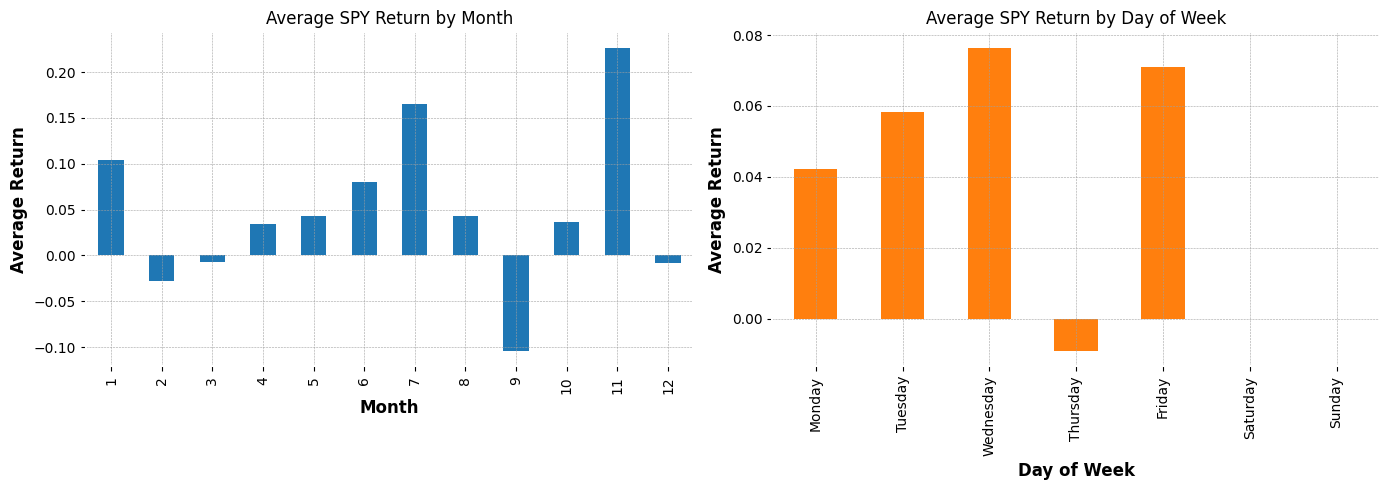

In [285]:

# 1. Compute the means
monthly_avg = return_data.groupby('month')['SPY_return'].mean()
weekday_avg = return_data.groupby('day_of_week')['SPY_return'].mean()

# (Optional) if your days aren't already in order Monday→Sunday:
weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
weekday_avg = weekday_avg.reindex(weekday_order)

# 2. Make a 1×2 subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# 3a. Plot months
monthly_avg.plot(kind='bar', ax=ax1)
ax1.set_title("Average SPY Return by Month")
ax1.set_xlabel("Month")
ax1.set_ylabel("Average Return")

# 3b. Plot days of week
weekday_avg.plot(kind='bar', ax=ax2, color='C1')
ax2.set_title("Average SPY Return by Day of Week")
ax2.set_xlabel("Day of Week")
ax2.set_ylabel("Average Return")

plt.tight_layout()
plt.show()


## To conclude :

I displayed the daily close price of the S&P500 and looked at its behaivor.
 I added external data such as economic data, treasury auctions, price-earning ratio on the s&p ,The external data help for a better 
 understanding of price and volatility behaivore. I didnt see for each data a significant price auction beahivor correlation.

 Seasonality :
 As it seems there is some seasonality, down average return in months in the first and third quartrer